# User Oriented Dataset - Cleaning - Adding New Features
- UDD/MDS18/PP4
- Final Project: 'Studying Twitter User Accounts: Spotting Suspicious Social Bot Behavior'
- Master Candidate: Marcelo Rovai
- Professors:	   
    - Eduardo Graells-Garrido (Supervisor)
    - Loreto Bravo
    - Leo Ferres

## Main Libraries

In [287]:
import pandas as pd
from pandas.plotting import table
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from urllib.request import urlopen
import re

In [2]:
pd.set_option('display.float_format', lambda x: '%.f' % x)
sns.set_context("paper", rc={"font.size":12,"axes.titlesize":12,"axes.labelsize":12})

## Main Functions

In [243]:
def get_twts_per_day(tweets):
    tw_day = []
    for d in range (1, 31):
        tw_day.append(len(tweets[tweets.day == d]))
    return tw_day

In [244]:
def get_max_tweet_day(tweets, user_list):
    max_twt_day = []
    for user_name in user_list:
        t = tweets[tweets.user == user_name].reset_index(drop=True)
        twt_day = get_twts_per_day(t)
        max_twt_day.append(max(twt_day))
    max_tweet_day_user = dict(zip(user_list, max_twt_day))
    max_tweet_day_user = sorted(max_tweet_day_user.items(), key=lambda x:x[1], reverse=True)
    return max_tweet_day_user

In [245]:
def verif_acc_active(user):
    url = "https://twitter.com/"
    try:
        html = urlopen(url+user).read()
        return True 
    except:
        return False

In [246]:
def get_hashtags(tweets):
    hashtags = []
    hashtag_pattern = re.compile(r"#[a-zA-Z]+")
    hashtag_matches = list(tweets['text'].apply(hashtag_pattern.findall))
    hashtag_dict = {}
    cnt = 0
    for match in hashtag_matches:
        for singlematch in match:
            if singlematch not in hashtag_dict.keys():
                hashtag_dict[singlematch] = 1
                cnt +=1
            else:
                hashtag_dict[singlematch] = hashtag_dict[singlematch]+1
                cnt +=1
    hashtag_ordered_list =sorted(hashtag_dict.items(), key=lambda x:x[1], reverse=True)
    return hashtag_ordered_list, len(hashtag_ordered_list), cnt

In [247]:
def get_mentions(tweets):
    mentions = []
    mention_pattern = re.compile(r"@[a-zA-Z_]+")
    mention_matches = list(tweets['text'].apply(mention_pattern.findall))
    mentions_dict = {}
    cnt = 0
    for match in mention_matches:
        for singlematch in match:
            if singlematch not in mentions_dict.keys():
                mentions_dict[singlematch] = 1
                cnt +=1
            else:
                mentions_dict[singlematch] = mentions_dict[singlematch]+1
                cnt +=1
    mentions_ordered_list =sorted(mentions_dict.items(), key=lambda x:x[1], reverse=True)
    return mentions_ordered_list, len(mentions_ordered_list), cnt

In [293]:
def print_user_features(tweets, user_name, prt=True, ver_act=False): 
    if ver_act == True:
        active_acc = verif_acc_active(user_name)
    else:
        active_acc = "Not checked" 
        
    t = tweets[tweets.user == user_name].reset_index(drop=True)

    user =  t.user.values[0]
    name = t.name.values[0]
    user_id = t.user_id.values[0]
    default_prof_image = t.default_prof_image.values[0]
    photo_url = t.image.values[0]
    acc_verif = t.verified.values[0]
    location = t.location.values[0]
    default_profile = t.default_profile.values[0]
    descr = t.description.values[0]  
    tws_cnt = t.tweets_cnt.values[0]
    frs_cnt = t.following.values[0]
    fols_cnt = t.followers.values[0]
    fav_cnt = t.favourites.values[0]
    
    if default_prof_image == False:
        if photo_url == 'http://abs.twimg.com/sticky/default_profile_images/default_profile_normal.png':
            default_prof_image = True
        else:
            default_prof_image = False
    
    if location == '': 
        local_bol = False
    else:
        local_bol = True
    
    if descr == '':
        descr_bol = False
    else:
        descr_bol = True
    
    tweets_analysed = len(t)
    
    last_tweet_date = t.created_at.values[-1]
    older_tweet_date = t.created_at.values[0]
    account_created_date = t.acc_creation.values[0]
    
    delta = last_tweet_date - account_created_date
    days = delta.astype('timedelta64[D]')
    account_age_days = days / np.timedelta64(1, 'D')
    
    recent_delta = last_tweet_date - older_tweet_date
    days = recent_delta.astype('timedelta64[D]')
    recent_age_days = days / np.timedelta64(1, 'D')  
    
    ave_acc_tw_day = round(tws_cnt/account_age_days, 2)
    ave_recent_tw_day = round(tweets_analysed/recent_age_days, 2)
    tw_day = get_twts_per_day(t)
    max_tweet_day = max(tw_day)

    if fav_cnt != 0:    
        rt_fv_idx = round(t.retweet_cnt.values[0]/fav_cnt, 2)
    else:
        rt_fv_idx = 0    
    
    if frs_cnt != 0:    
        fl_fw_idx = round(fols_cnt/frs_cnt, 2)
    else:
        fl_fw_idx = 0
    
    RT_tweets = t[t['RT'] == True]
    rt_tweets_cnt =  len(RT_tweets)   
    rt_ratio = round(rt_tweets_cnt/tweets_analysed*100)

    ment_tweets = t[t['num_mentions'] !=0]
    ment_tweets_cnt = len(ment_tweets)
    ment_ratio = round(ment_tweets_cnt/tweets_analysed*100)
    
    hash_tweets = t[t['num_hashtags'] !=0]
    hash_tweets_cnt = len(hash_tweets)
    hash_ratio = round(hash_tweets_cnt/tweets_analysed*100)
    
    mentions, unique_mentions_cnt, ment_cnt = get_mentions(t)
    hashtags, unique_hashtags_cnt, hash_cnt = get_hashtags(t)
    
    try:
        ment_idx = round(unique_mentions_cnt/ment_cnt, 2)
    except:
        ment_idx = 0.0
    try:
        hash_idx = round(unique_hashtags_cnt/hash_cnt, 2) 
    except:
        hash_idx = 0.0
        
    mean_urls = round(t.num_urls.values.mean(), 2)
    mean_lenght = round(t.lenght.values.mean(),0)
 
    # New Features   
    user_len = len(user)
    name_len = len(name)
    descr_len = len(descr)
    
    temp = re.findall(r'\d+', user)
    if len(temp) == 0:
        user_len_num = 0
    else:
        user_len_num = len(temp[0])
    
    try:
        simil_name = 100*(jaccard_similarity(user, name))
    except:
        simil_name = 0          
    
    if frs_cnt != 0:    
        fols_frs_ratio = round(fols_cnt/frs_cnt, 2)
    else:
        fols_frs_ratio = 0
    
    metrics = [
        user, user_id, name, default_prof_image, photo_url, acc_verif, 
        location, local_bol, default_profile, descr, descr_bol, active_acc, tws_cnt, frs_cnt, 
        fols_cnt, fav_cnt, fl_fw_idx, last_tweet_date, older_tweet_date, 
        tweets_analysed, account_age_days, ave_acc_tw_day, 
        ave_recent_tw_day, max_tweet_day, ment_tweets_cnt, hash_tweets_cnt, 
        unique_mentions_cnt, unique_hashtags_cnt, ment_idx, hash_idx, 
        rt_ratio, mean_urls, mean_lenght, recent_age_days, user_len, name_len,
        user_len_num, simil_name, descr_len
    ]
    
    if prt == True:   
        print("\nInfo Data for @" + user)
        print("\nName:                      ", name)
        print("Name Length:               ", name_len)
        print("@user number Numeric Chars:", user_len_num)
        print("@user and name similarity: ", simil_name)
        print("User Id:                   ", user_id)
        print("Default_Photo:             ", default_prof_image)
        print("Photo URL:                 ", photo_url)
        print("Acc Verified:              ", acc_verif)
        print("Has Location:              ", local_bol)
        print("Location:                  ", location)
        print("default_profile:           ", default_profile)
        print("Has Description:           ", descr_bol)
        print("Description:               ", descr) 
        print("Description length:        ", descr_len) 
        print("Account Active:            ", active_acc)

        print("\nNumber of Tweets analyzed:         ", tweets_analysed)
        print("Last Tweet:                        ", last_tweet_date)
        print("Older Tweet Analyzed:              ", older_tweet_date)
        print("Account Active age (in days)        {0:,}".format(account_age_days))
        print("Average recent tweets per day:      {}".format(ave_recent_tw_day))
        print("Maximum Recent Tweets Per Day:      {}".format(max_tweet_day))
        print("Average tweets per day since start: {}".format(ave_acc_tw_day))
        print("Total Tweets since start:           {0:,}".format(tws_cnt))
        print("Followers_count:                    {0:,}".format(fols_cnt))
        print("Friends_following_count             {0:,}".format(frs_cnt))
        print("Followers/Following_index:          {}".format(fl_fw_idx)) 
        print("Favourites (Like) count:            {0:,}".format(fav_cnt))       
        print("Retweet_Like_index:                 {}".format(rt_fv_idx)) 
        print("Retweet Ratio:                      {}%".format(rt_ratio))
        print("unique mentions cnt:                {}".format(unique_mentions_cnt)) 
        print("Mention Ratio:                      {}%".format(ment_ratio))
        print("Mention index:                      {}".format(ment_idx))
        print("unique hashtags cnt:                {}".format(unique_hashtags_cnt))     
        print("Hashtag Ratio:                      {}%".format(hash_ratio))
        print("Hashtag Index:                      {}".format(hash_idx))
        print("Average URLs per tweet:             {}".format(mean_urls))
        print("Average text length per tweet:      {}".format(mean_lenght))
    
    return tw_day, metrics, mentions, hashtags

In [250]:
def plot_feature(df, feat, kde=True, prt=False, save_file_name=None, x_max = None):
    f, axes = plt.subplots(ncols=1, figsize=(10, 4))
    sns.despine(left=True)
    sns.distplot(df[feat],
                 color="m",
                 hist=False,
                 kde=kde,
                 kde_kws={
                     'shade': True,
                     'linewidth': 3
                 })
    plt.suptitle(feat + " distribution", fontsize=20)
    plt.xlabel(feat,fontsize=15)
    plt.setp(axes, yticks=[])
    plt.xlim(0, x_max)

    if prt == True:
        plt.savefig("../images/"+save_file_name, bbox_inches='tight')

In [330]:
def plot_user_timeline(user_name, tw_day, prt=False):   
    f, axes = plt.subplots(ncols=1, figsize=(10, 4))
    plt.suptitle("@"+user_name+" - Number of Tweets per day", fontsize = 20)
    sns.despine()
    plt.xlabel("day of the month",fontsize=15)
    plt.ylabel("# tweets",fontsize=15)
    plt.bar(range(1, 31), tw_day);
    
    if prt == True:
        plt.savefig("../images/"+user_name+" - Timeline", bbox_inches='tight')

In [337]:
def get_info_data(tweets, user_name, ver_act=True, prt=False):
    tw_day, metrics, mentions, hastags = print_user_features(tweets, user_name, ver_act=ver_act)
    print("\n \t[Tweets Sample] \n", tweets[(tweets.user == user_name)].text[:10])
    plot_user_timeline(user_name, tw_day, prt=prt)
    return tw_day, metrics, mentions, hastags

## Get Datasets

In [5]:
ls ../data/

20_tweets_nov_2017.csv          45_user_adit_clean_metrics.csv
30_tweets_nov_2017_final.csv    50_user_metrics_final.csv
40_user_metrics.csv


In [583]:
df = pd.read_csv("../data/40_user_metrics.csv", lineterminator='\n', low_memory=False)
df.shape

(105944, 32)

In [584]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105944 entries, 0 to 105943
Data columns (total 32 columns):
user                   105944 non-null object
user_id                105941 non-null object
name                   105936 non-null object
default_prof_image     105941 non-null object
photo_url              105941 non-null object
acc_verif              105941 non-null object
location               70844 non-null object
local_bol              105941 non-null object
default_profile        105941 non-null object
descr                  77432 non-null object
descr_bol              91550 non-null object
active_acc             91550 non-null object
tws_cnt                91550 non-null float64
frs_cnt                91550 non-null float64
fols_cnt               91550 non-null float64
fav_cnt                91550 non-null float64
last_tweet_date        91550 non-null object
older_tweet_date       91550 non-null object
tweets_analysed        91550 non-null float64
account_age_days     

### Cleaning

In [585]:
df.descr.fillna('', inplace=True)
df.location.fillna('', inplace=True)
df.name.fillna('', inplace=True)

In [586]:
df[df.user == 'EstoyConPinera']

,user,user_id,name,default_prof_image,photo_url,acc_verif,location,local_bol,default_profile,descr,...,max_tweet_day,ment_tweets_cnt,hash_tweets_cnt,unique_mentions_cnt,unique_hashtags_cnt,ment_idx,hash_idx,rt_ratio,mean_urls,mean_lenght
0,EstoyConPinera,840624094265643008,Estoy Con Piñera,False,http://pbs.twimg.com/profile_images/9255397516...,False,Chile,True,False,Comunidad de adherentes al candidato de Chile ...,...,848,2511,1884,31,10,0,0,0,0,196
4933,EstoyConPinera,840624094265643008,Estoy Con Piñera,False,http://pbs.twimg.com/profile_images/9255397516...,False,Chile,True,False,Comunidad de adherentes al candidato de Chile ...,...,848,2511,1884,31,10,0,0,0,0,196


In [587]:
df = df.drop(df.index[0])

In [588]:
df.user.value_counts()

matiburgos         8546
DonMuttley         5641
chrispulgar         194
leobarahona           1
Lkko65                1
parebolledof          1
zephw3st              1
barbarelash           1
DonCokeArayaT         1
chino_vlady           1
Marce_1512            1
DomiTaborga           1
palomadiazlobos       1
CamiloVj              1
Alescudero_UC         1
Laevearavena          1
Piia_sn               1
Maurici70228462       1
rcrodrigopro          1
bigotesnegros         1
Carrascobcami         1
canelalorca           1
bdorivera             1
Angelic55610588       1
fcoastorgatoro        1
ChunchoZuniga         1
MonseRodrigo          1
Bsepulvedav           1
MIGUELORIANO          1
KVZ_MILLWALL          1
                   ... 
PaolaSantander7       1
reclamos              1
elmejoredux           1
1charlyharper         1
Lsanmar13             1
MaluRojasG            1
NawrathMabel          1
ConcienciaVial_       1
Billy_Guevara         1
claudiobustios        1
mmoralesbarrera 

In [589]:
df.mean_lenght.isnull().sum()

14407

In [590]:
df = df.dropna(axis=0, subset=['mean_lenght'])

In [591]:
df.mean_lenght.isnull().sum()

0

In [592]:
df.user.value_counts()

leobarahona        1
juliopuluki        1
Angelic55610588    1
parebolledof       1
zephw3st           1
barbarelash        1
DonCokeArayaT      1
chino_vlady        1
Marce_1512         1
DomiTaborga        1
palomadiazlobos    1
Lkko65             1
CamiloVj           1
Laevearavena       1
Piia_sn            1
Maurici70228462    1
rcrodrigopro       1
bigotesnegros      1
Carrascobcami      1
canelalorca        1
bdorivera          1
Alescudero_UC      1
ChunchoZuniga      1
fcoastorgatoro     1
GoicLover          1
tomas_lyon         1
Bsepulvedav        1
MIGUELORIANO       1
KVZ_MILLWALL       1
Robin_jonhson      1
                  ..
elmejoredux        1
1charlyharper      1
Lsanmar13          1
MaluRojasG         1
NawrathMabel       1
AC_Akb             1
osvaldo_pacheco    1
PayasoTriste13     1
ConcienciaVial_    1
carmenaraucania    1
LueizaBoris        1
JavierSuanes       1
seba6008           1
aloayzah           1
nachibernasconi    1
jlguzmanro         1
ctm_tkg      

In [593]:
df.head()

,user,user_id,name,default_prof_image,photo_url,acc_verif,location,local_bol,default_profile,descr,...,max_tweet_day,ment_tweets_cnt,hash_tweets_cnt,unique_mentions_cnt,unique_hashtags_cnt,ment_idx,hash_idx,rt_ratio,mean_urls,mean_lenght
1,T13,24952459,Tele13,False,http://pbs.twimg.com/profile_images/7109221102...,True,"Santiago, Chile",True,False,Cuenta oficial de las plataformas informativas...,...,1376,1676,5689,35,16,0,0,1,2,162
2,nostromar,2955687197,Constanza Lewis,False,http://pbs.twimg.com/profile_images/8881491353...,False,,False,True,Defiendo a los animales del mundo y de mi país...,...,17,137,14,123,15,0,1,84,0,131
3,Chicavalpo,883906441496735744,Chiquita,False,http://abs.twimg.com/sticky/default_profile_im...,False,,False,True,,...,6,35,0,38,0,0,0,0,0,141
4,corrupcionchile,3015470117,Corrupción Chile,False,http://pbs.twimg.com/profile_images/8062983571...,False,Chile,True,False,Medio Digital Libertario #Libertad #Economía #...,...,522,1,20,1,2,1,0,0,1,130
5,abalosfelipe,82963099,Felipe Abalos,False,http://pbs.twimg.com/profile_images/9149677410...,False,Chile,True,False,"Trabajando #PorUnChileMasJusto, Militante UDI,...",...,240,655,725,108,20,0,0,5,1,224


In [594]:
df['last_tweet_date'] = pd.to_datetime(df['last_tweet_date'], infer_datetime_format = "%d/%m/%Y", utc  = False)
df['older_tweet_date'] = pd.to_datetime(df['older_tweet_date'], infer_datetime_format = "%d/%m/%Y", utc  = False)

In [595]:
df = df[(df['last_tweet_date'] > '2017-10-31')
        & (df['last_tweet_date'] < '2017-12-01')]

df = df[(df['older_tweet_date'] > '2017-10-31')
        & (df['older_tweet_date'] < '2017-12-01')]

len(df)

91154

In [596]:
df.default_prof_image.value_counts()

False    91154
Name: default_prof_image, dtype: int64

In [597]:
df.photo_url.value_counts()

http://abs.twimg.com/sticky/default_profile_images/default_profile_normal.png                                     7949
http://pbs.twimg.com/profile_images/911077003339558912/52v9cvg7_normal.jpg                                           3
http://pbs.twimg.com/profile_images/495781580229472256/MNIxe4P5_normal.jpeg                                          3
http://pbs.twimg.com/profile_images/760839022516248576/aVSjmhDw_normal.jpg                                           3
http://pbs.twimg.com/profile_images/924156409532616704/cbmFflRV_normal.jpg                                           3
http://pbs.twimg.com/profile_images/914676551236620289/JcBSFF0a_normal.jpg                                           3
http://pbs.twimg.com/profile_images/927922676622135297/u1D1fQKx_normal.jpg                                           3
http://pbs.twimg.com/profile_images/916322988483579906/nVtaIAGx_normal.jpg                                           3
http://pbs.twimg.com/profile_images/926204432345

Convert original boolean (True/False) features in (1/0)

In [598]:
df.default_profile.value_counts()

True     49441
False    41713
Name: default_profile, dtype: int64

In [599]:
df.acc_verif.value_counts()

False    90993
True       161
Name: acc_verif, dtype: int64

In [600]:
def conv_bool_int(row):
    photo_url = row.photo_url
    acc_verif = row.acc_verif
    local_bol = row.local_bol
    descr_bol = row.descr_bol
    active_acc = row.active_acc
    default_profile = row.default_profile
    
    if photo_url == 'http://abs.twimg.com/sticky/default_profile_images/default_profile_normal.png':
        default_prof_image = 1
    else:
        default_prof_image = 0
        
    if acc_verif == 'True':
        acc_verif = 1
    else:
        acc_verif = 0  
        
    if local_bol == 'True':
        local_bol = 1
    else:
        local_bol = 0
        
    if descr_bol == 'True':
        descr_bol = 1
    else:
        descr_bol = 0
        
    if active_acc == 'True':
        active_acc = 1
    else:
        active_acc = 0
            
    if default_profile == 'True':
        default_profile = 1
    else:
        default_profile = 0
        
    row['default_prof_image'] = default_prof_image
    row['default_profile'] = default_profile
    row['acc_verif'] = acc_verif
    row['local_bol'] = local_bol
    row['descr_bol'] = descr_bol
    row['active_acc'] = active_acc
    
    return row

In [601]:
df = df.apply(conv_bool_int, axis=1)

In [602]:
df = df.reset_index(drop=True)

In [603]:
df.default_prof_image.value_counts()

0    83205
1     7949
Name: default_prof_image, dtype: int64

In [604]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
default_prof_image,91154,0,0,0,0,0,0,1
acc_verif,91154,0,0,0,0,0,0,1
local_bol,91154,1,0,0,0,1,1,1
default_profile,91154,1,0,0,0,1,1,1
descr_bol,91154,1,0,0,0,1,1,1
active_acc,91154,1,0,0,1,1,1,1
tws_cnt,91154,9199,28376,1,231,1406,6628,1386920
frs_cnt,91154,754,4237,0,106,302,775,761106
fols_cnt,91154,1599,29395,0,33,141,500,2882527
fav_cnt,91154,2316,8656,0,55,337,1557,897789


In [605]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91154 entries, 0 to 91153
Data columns (total 32 columns):
user                   91154 non-null object
user_id                91154 non-null object
name                   91154 non-null object
default_prof_image     91154 non-null int64
photo_url              91154 non-null object
acc_verif              91154 non-null int64
location               91154 non-null object
local_bol              91154 non-null int64
default_profile        91154 non-null int64
descr                  91154 non-null object
descr_bol              91154 non-null int64
active_acc             91154 non-null int64
tws_cnt                91154 non-null float64
frs_cnt                91154 non-null float64
fols_cnt               91154 non-null float64
fav_cnt                91154 non-null float64
last_tweet_date        91154 non-null datetime64[ns]
older_tweet_date       91154 non-null datetime64[ns]
tweets_analysed        91154 non-null float64
account_age_days     

The features related to average tweets per day had some errors and were re-calculated:

In [606]:
def review_ave_tw_day(row):   
    
    tweets_analysed = row.tweets_analysed    
    last_tweet_date = row.last_tweet_date
    older_tweet_date = row.older_tweet_date
    account_age_days = row.account_age_days
    recent_age_days = (last_tweet_date - older_tweet_date).days
    if account_age_days == 0: account_age_days = 1
    if recent_age_days <= 0: recent_age_days = 1
    
    row['recent_age_days'] = recent_age_days
    row['ave_acc_tw_day'] = int(row.tws_cnt/account_age_days)
    row['ave_recent_tw_day'] = int(tweets_analysed/recent_age_days)
    return row

In [607]:
df = df.apply(review_ave_tw_day, axis=1)

The features related to mentions/hashtags had some errors and were re-calculated:

In [608]:
def review_hash_ment_idx(row):  
    unique_mentions_cnt = row.unique_mentions_cnt
    ment_tweets_cnt = row.ment_tweets_cnt
    unique_hashtags_cnt = row.unique_hashtags_cnt
    hash_tweets_cnt = row.hash_tweets_cnt
        
    try:
        ment_idx = round(unique_mentions_cnt/ment_tweets_cnt, 2)
    except:
        ment_idx = 0.0
    try:
        hash_idx = round(unique_hashtags_cnt/hash_tweets_cnt, 2) 
    except:
        hash_idx = 0.0
    
    row['ment_idx'] = ment_idx
    row['hash_idx'] = hash_idx
    return row

In [609]:
df = df.apply(review_hash_ment_idx, axis=1)

In [610]:
tot_tweets = int(df.tweets_analysed.sum())

In [611]:
print("Total Tweets analyzed: {:,}".format(tot_tweets))

Total Tweets analyzed: 1,492,991


## Adding new features

Human user tend to have screen name (user_name) similar to its name and with few (or none) numbers. 
- Calculate the similarity between name and user name, by having Jaccard similarity between the set of letter of both features. 
- Create a feature with the number of digits 

In [264]:
def jaccard_similarity(cont1, cont2):
    cont1 = "".join(re.split("[^a-zA-Z]*", cont1.lower()))
    cont2 = "".join(re.split("[^a-zA-Z]*", cont2.lower()))
    cont1_simil= set(cont1)
    cont2_simil = set(cont2)
    intersection = cont1_simil.intersection(cont2_simil)
    return float(len(intersection)) / (len(cont1_simil) + len(cont2_simil) - len(intersection))    

In [613]:
# test fuction 
cont1 = 'marcelo Rovai'
cont2 = 'mjrovai'
jaccard_similarity(cont1, cont2)

0.6

In [614]:
# test fuction 
cont1 = str(df.name[0])
cont2 = str(df.user[0])
float(jaccard_similarity(cont1, cont2))

0.3333333333333333

In [625]:
def add_new_users_feat(row): 
    user_name = str(row['user'])
    name = str(row['name'])
    descr = str(row['descr'])
    fols_cnt = row['fols_cnt']
    frs_cnt = row['frs_cnt']

    user_name_len = len(user_name)
    name_len = len(name)
    descr_len = len(descr)
    
    temp = re.findall(r'\d+', user_name)
    if len(temp) == 0:
        user_name_len_num = 0
    else:
        user_name_len_num = len(temp[0])
    
    try:
        simil_name = 100*(jaccard_similarity(user_name, name))
    except:
        simil_name = 0          
    
    if frs_cnt != 0:    
        fols_frs_ratio = round(fols_cnt/frs_cnt, 2)
    else:
        fols_frs_ratio = 0
        
    row['user_name_len'] = user_name_len
    row['name_len'] = len(name)
    row['user_name_len_num'] = user_name_len_num
    row['simil_name'] = simil_name
    row['descr_len'] = descr_len
    row['fols_frs_ratio'] = fols_frs_ratio
    return row

In [626]:
df = df.apply(add_new_users_feat, axis=1)

In [627]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
default_prof_image,91154,0,0,0,0,0,0,1
acc_verif,91154,0,0,0,0,0,0,1
local_bol,91154,1,0,0,0,1,1,1
default_profile,91154,1,0,0,0,1,1,1
descr_bol,91154,1,0,0,0,1,1,1
active_acc,91154,1,0,0,1,1,1,1
tws_cnt,91154,9199,28376,1,231,1406,6628,1386920
frs_cnt,91154,754,4237,0,106,302,775,761106
fols_cnt,91154,1599,29395,0,33,141,500,2882527
fav_cnt,91154,2316,8656,0,55,337,1557,897789


In [646]:
df.to_csv("../data/45_user_adit_clean_metrics.csv")

In [647]:
data = df.copy()

In [649]:
del data['user_id']
del data['name']
del data['photo_url']
del data['location']
del data['descr']
del data['last_tweet_date']
del data['older_tweet_date']

In [650]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91154 entries, 0 to 91153
Data columns (total 32 columns):
user                   91154 non-null object
default_prof_image     91154 non-null int64
acc_verif              91154 non-null int64
local_bol              91154 non-null int64
default_profile        91154 non-null int64
descr_bol              91154 non-null int64
active_acc             91154 non-null int64
tws_cnt                91154 non-null float64
frs_cnt                91154 non-null float64
fols_cnt               91154 non-null float64
fav_cnt                91154 non-null float64
tweets_analysed        91154 non-null float64
account_age_days       91154 non-null float64
ave_acc_tw_day         91154 non-null int64
ave_recent_tw_day      91154 non-null int64
max_tweet_day          91154 non-null float64
ment_tweets_cnt        91154 non-null float64
hash_tweets_cnt        91154 non-null float64
unique_mentions_cnt    91154 non-null float64
unique_hashtags_cnt    91154 non-n

In [652]:
data.to_csv("../data/50_user_metrics_final.csv")

## User Metrics dataset EDA

In [7]:
ls ../data/

20_tweets_nov_2017.csv             50_user_metrics_final.csv
30_tweets_nov_2017_final.csv       df_user_description.csv
40_user_metrics.csv                select_tweet_feat_description.csv
45_user_adit_clean_metrics.csv


In [8]:
df_user = pd.read_csv("../data/50_user_metrics_final.csv", lineterminator='\n', low_memory=False)
df_user.shape

(91154, 33)

In [9]:
df_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91154 entries, 0 to 91153
Data columns (total 33 columns):
Unnamed: 0             91154 non-null int64
user                   91154 non-null object
default_prof_image     91154 non-null int64
acc_verif              91154 non-null int64
local_bol              91154 non-null int64
default_profile        91154 non-null int64
descr_bol              91154 non-null int64
active_acc             91154 non-null int64
tws_cnt                91154 non-null float64
frs_cnt                91154 non-null float64
fols_cnt               91154 non-null float64
fav_cnt                91154 non-null float64
tweets_analysed        91154 non-null float64
account_age_days       91154 non-null float64
ave_acc_tw_day         91154 non-null int64
ave_recent_tw_day      91154 non-null int64
max_tweet_day          91154 non-null float64
ment_tweets_cnt        91154 non-null float64
hash_tweets_cnt        91154 non-null float64
unique_mentions_cnt    91154 non-nul

In [252]:
df_user.columns

Index(['user', 'default_prof_image', 'acc_verif', 'local_bol',
       'default_profile', 'descr_bol', 'active_acc', 'tws_cnt', 'frs_cnt',
       'fols_cnt', 'fav_cnt', 'tweets_analysed', 'account_age_days',
       'ave_acc_tw_day', 'ave_recent_tw_day', 'max_tweet_day',
       'ment_tweets_cnt', 'hash_tweets_cnt', 'unique_mentions_cnt',
       'unique_hashtags_cnt', 'ment_idx', 'hash_idx', 'rt_ratio', 'mean_urls',
       'mean_lenght', 'recent_age_days', 'user_name_len', 'name_len',
       'user_name_len_num', 'simil_name', 'descr_len', 'fols_frs_ratio',
       'label'],
      dtype='object')

In [10]:
tot_tweets = int(df_user.tweets_analysed.sum())
print("Total Tweets analyzed: {:,}".format(tot_tweets))

Total Tweets analyzed: 1,492,991


In [11]:
del df_user['Unnamed: 0']

In [12]:
df_user.describe().T

,count,mean,std,min,25%,50%,75%,max
default_prof_image,91154,0,0,0,0,0,0,1
acc_verif,91154,0,0,0,0,0,0,1
local_bol,91154,1,0,0,0,1,1,1
default_profile,91154,1,0,0,0,1,1,1
descr_bol,91154,1,0,0,0,1,1,1
active_acc,91154,1,0,0,1,1,1,1
tws_cnt,91154,9199,28376,1,231,1406,6628,1386920
frs_cnt,91154,754,4237,0,106,302,775,761106
fols_cnt,91154,1599,29395,0,33,141,500,2882527
fav_cnt,91154,2316,8656,0,55,337,1557,897789


In [72]:
df_user.describe().T.to_csv("../data/df_user_description.csv")

In [58]:
from pandas.plotting import table

In [67]:
def print_save_table(data, prt=False, save_file_name=None):
        desc = data.describe()

        #create a subplot without frame
        plot = plt.subplot(111, frame_on=False)

        #remove axis
        plot.xaxis.set_visible(False) 
        plot.yaxis.set_visible(False) 

        #create the table plot and position it in the upper left corner
        table(plot, desc,loc='upper right');

        #save the plot as a png file
        if prt == True:
            plt.savefig("../images/"+save_file_name, bbox_inches='tight')

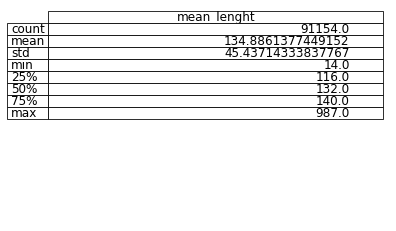

In [70]:
print_save_table(df_user.mean_lenght, prt=False, save_file_name=None)

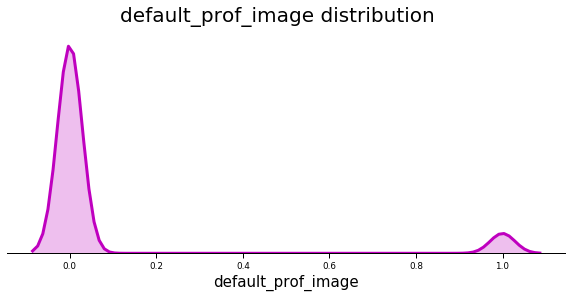

In [25]:
feat = 'default_prof_image'
plot_feature(df_user, feat, prt=False, save_file_name=None)

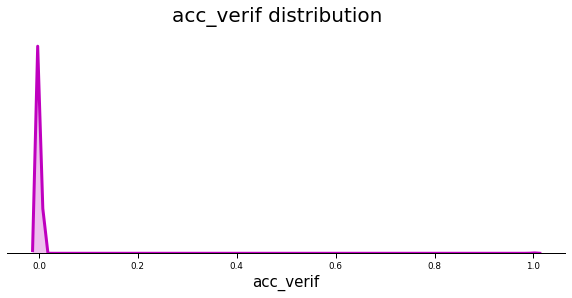

In [26]:
feat = 'acc_verif'
plot_feature(df_user, feat, prt=False, save_file_name=None)

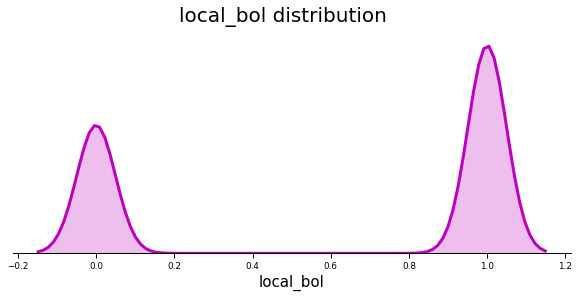

In [27]:
feat = 'local_bol'
plot_feature(df_user, feat, prt=False, save_file_name=None)

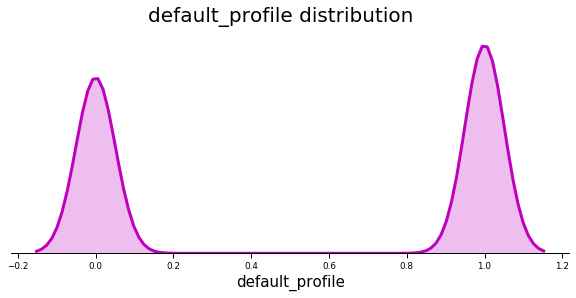

In [28]:
feat = 'default_profile'
plot_feature(df_user, feat, prt=False, save_file_name=None)

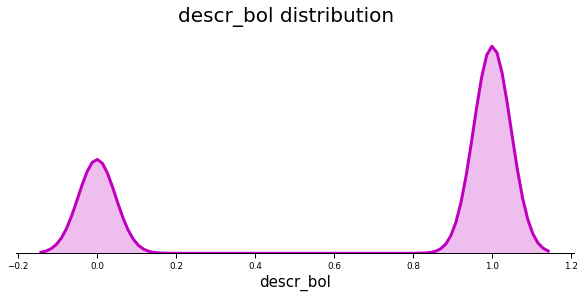

In [29]:
feat = 'descr_bol'
plot_feature(df_user, feat, prt=False, save_file_name=None)

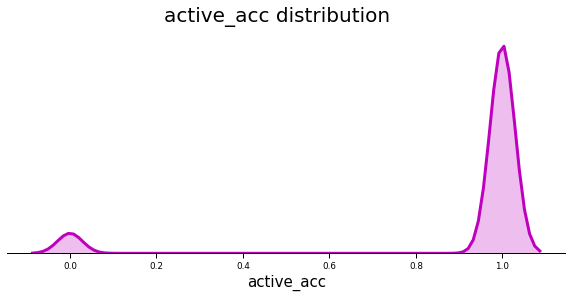

In [30]:
feat = 'active_acc'
plot_feature(df_user, feat, prt=False, save_file_name=None)

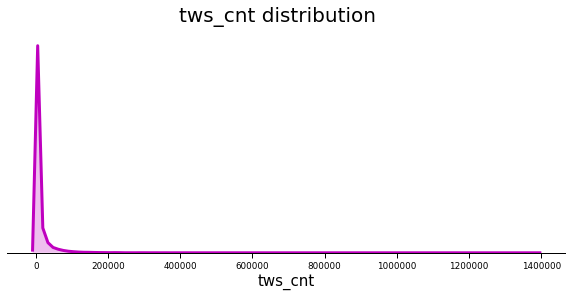

In [31]:
feat = 'tws_cnt'
plot_feature(df_user, feat, prt=False, save_file_name=None)

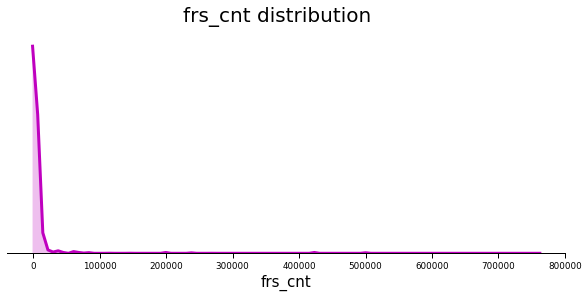

In [101]:
feat = 'frs_cnt'
plot_feature(df_user, feat, prt=False, save_file_name=None)

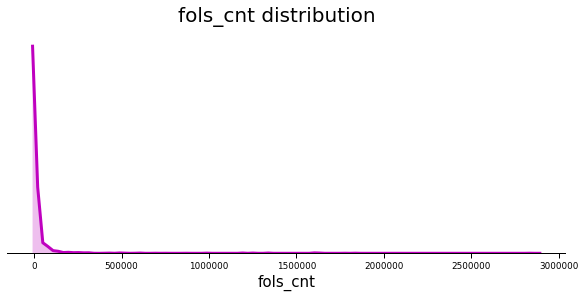

In [102]:
feat = 'fols_cnt'
plot_feature(df_user, feat, prt=False, save_file_name=None)

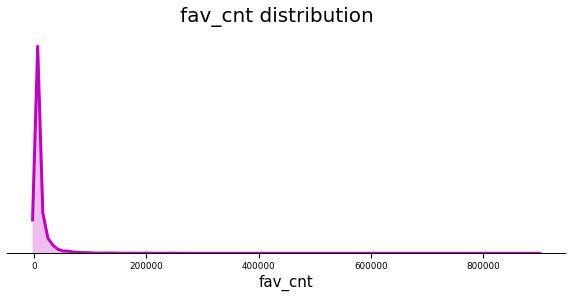

In [103]:
feat = 'fav_cnt'
plot_feature(df_user, feat, prt=False, save_file_name=None)

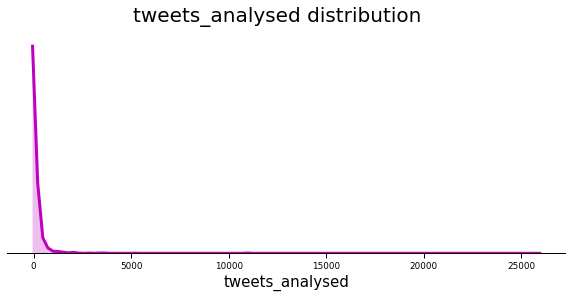

In [104]:
feat = 'tweets_analysed'
plot_feature(df_user, feat, prt=False, save_file_name=None)

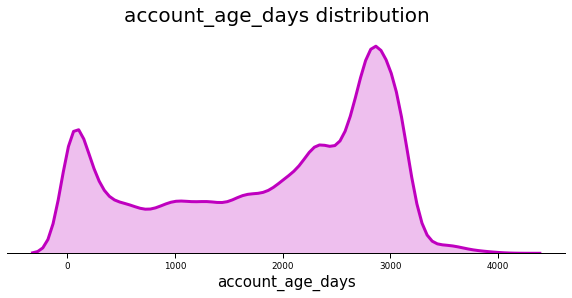

In [39]:
feat = 'account_age_days'
plot_feature(df_user, feat, prt=True, save_file_name='account_age_days', x_max=None)

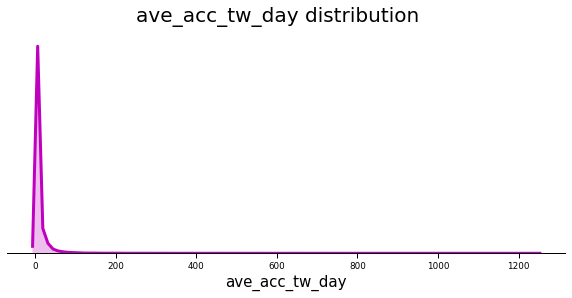

In [32]:
feat = 'ave_acc_tw_day'
plot_feature(df_user, feat, prt=False, save_file_name='XXX', x_max=None)

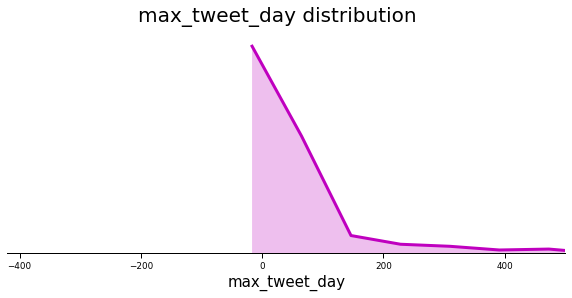

In [34]:
feat = 'max_tweet_day'
plot_feature(df_user, feat, prt=False, save_file_name='XXX', x_max=500)

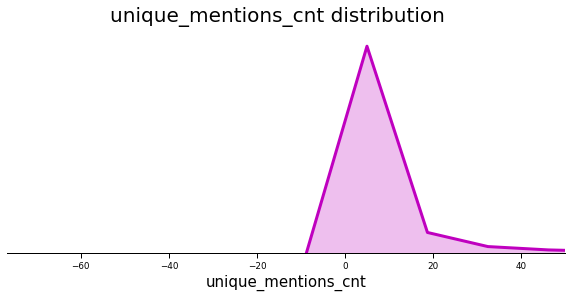

In [36]:
feat = 'unique_mentions_cnt'
plot_feature(df_user, feat, prt=False, save_file_name='XXX', x_max=50)

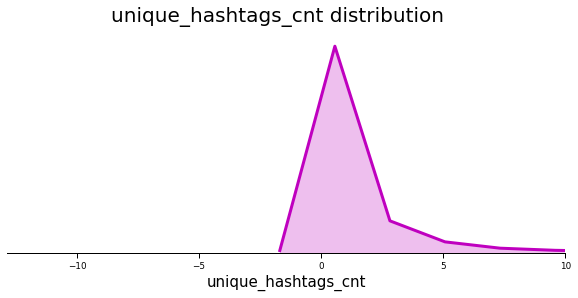

In [38]:
feat = 'unique_hashtags_cnt'
plot_feature(df_user, feat, prt=False, save_file_name='XXX', x_max=10)

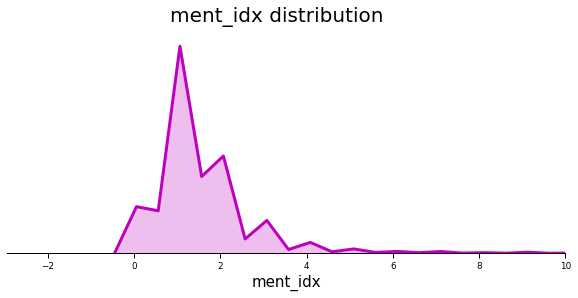

In [41]:
feat = 'ment_idx'
plot_feature(df_user, feat, prt=False, save_file_name='XXX', x_max=10)

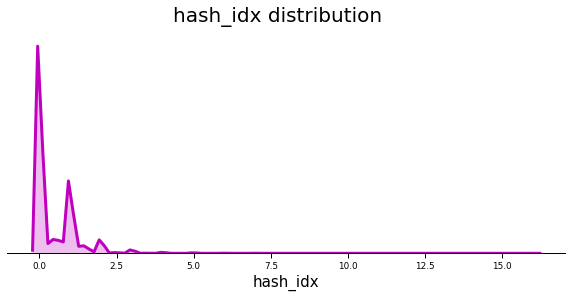

In [43]:
feat = 'hash_idx'
plot_feature(df_user, feat, prt=False, save_file_name='XXX', x_max=None)

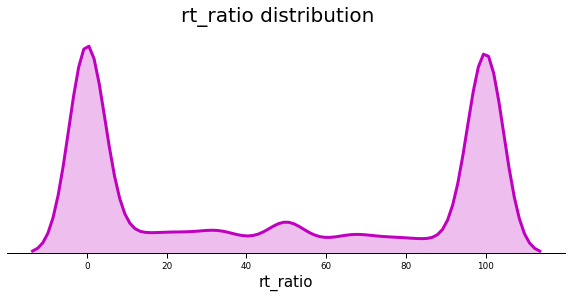

In [45]:
feat = 'rt_ratio'
plot_feature(df_user, feat, prt=True, save_file_name='Retweet_ratio', x_max=None)

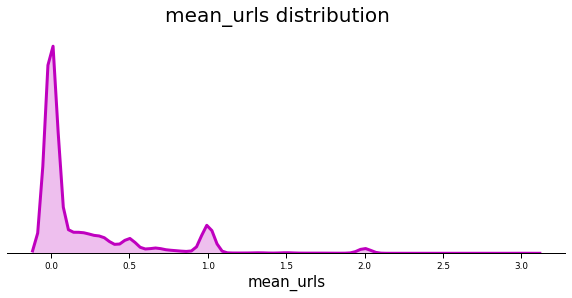

In [47]:
feat = 'mean_urls'
plot_feature(df_user, feat, prt=True, save_file_name='mean_urls', x_max=None)

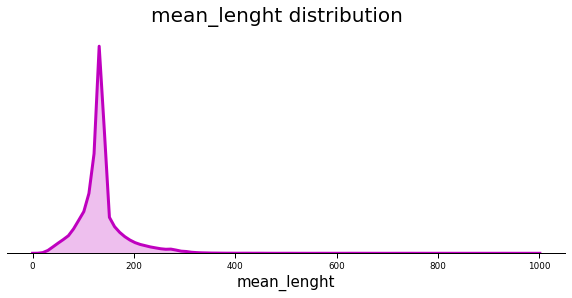

In [51]:
feat = 'mean_lenght'
plot_feature(df_user, feat, prt=True, save_file_name='user_tweets_mean_lenght', x_max=None)

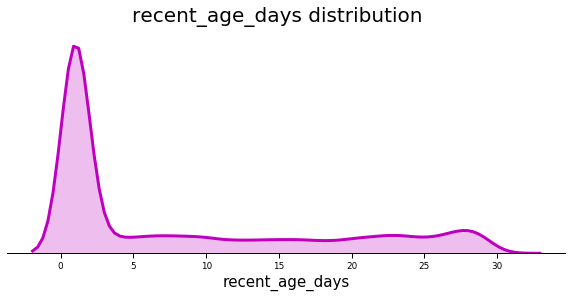

In [53]:
feat = 'recent_age_days'
plot_feature(df_user, feat, prt=True, save_file_name='recent_age_days', x_max=None)

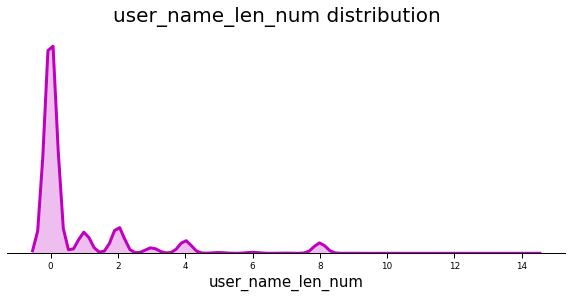

In [65]:
feat = 'user_name_len_num'
plot_feature(df_user, feat, prt=True, save_file_name='user_name_len_num', x_max=None)

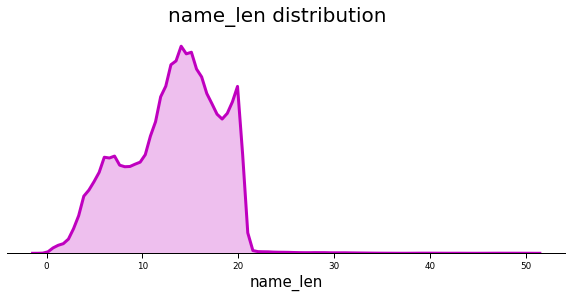

In [66]:
feat = 'name_len'
plot_feature(df_user, feat, prt=False, save_file_name='name_len', x_max=None)

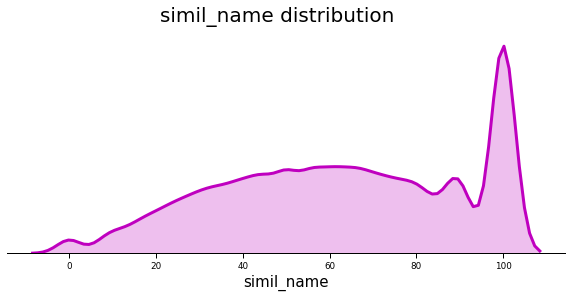

In [68]:
feat = 'simil_name'
plot_feature(df_user, feat, prt=True, save_file_name='simil_name', x_max=None)

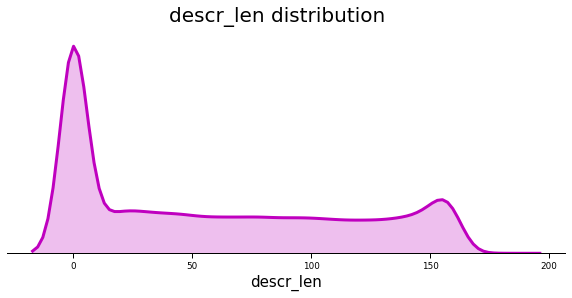

In [70]:
feat = 'descr_len'
plot_feature(df_user, feat, prt=True, save_file_name='descr_len', x_max=None)

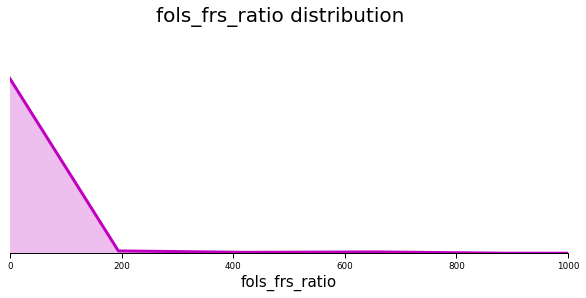

In [76]:
feat = 'fols_frs_ratio'
plot_feature(df_user, feat, prt=False, save_file_name='fols_frs_ratio', x_max=1000)

In [77]:
df_user.columns

Index(['user', 'default_prof_image', 'acc_verif', 'local_bol',
       'default_profile', 'descr_bol', 'active_acc', 'tws_cnt', 'frs_cnt',
       'fols_cnt', 'fav_cnt', 'tweets_analysed', 'account_age_days',
       'ave_acc_tw_day', 'ave_recent_tw_day', 'max_tweet_day',
       'ment_tweets_cnt', 'hash_tweets_cnt', 'unique_mentions_cnt',
       'unique_hashtags_cnt', 'ment_idx', 'hash_idx', 'rt_ratio', 'mean_urls',
       'mean_lenght', 'recent_age_days', 'user_name_len', 'name_len',
       'user_name_len_num', 'simil_name', 'descr_len', 'fols_frs_ratio'],
      dtype='object')

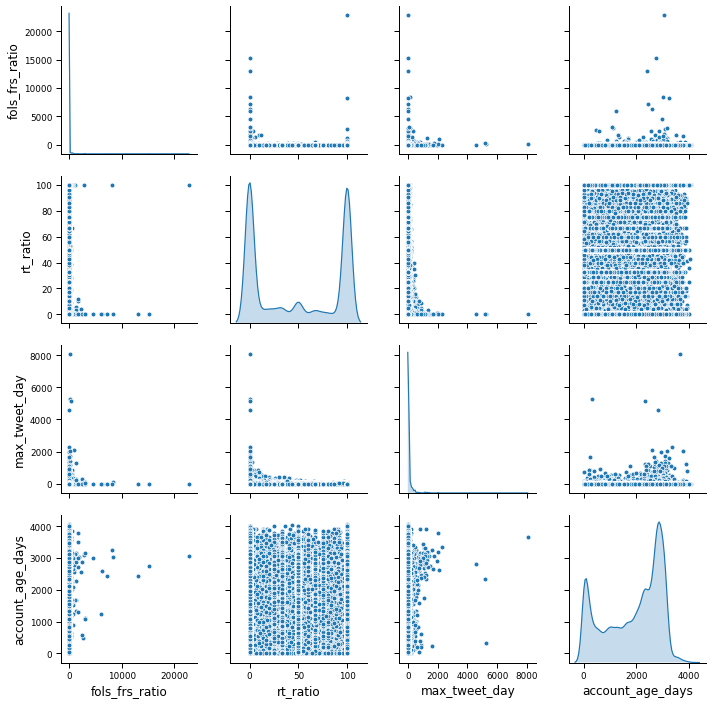

In [83]:
data = df_user[['fols_frs_ratio', 'rt_ratio', 'max_tweet_day', 'account_age_days']]
sns.pairplot(data, diag_kind="kde");

### Analyzing High Frequency User

In [84]:
hi_freq_users = df_user[(df_user.max_tweet_day > 71)]
hi_freq_tws = hi_freq_users.tweets_analysed.sum()

In [85]:
print("Number of user accounts with more than 72 tweets/day: {}".format(
    len(hi_freq_users)))

Number of user accounts with more than 72 tweets/day: 780


In [86]:
print("Number of tweets per Hi Freq Acc: {:,} ==> {}% of total tweets".format(
    hi_freq_tws, round((hi_freq_tws/tot_tweets)*100, 2)))

Number of tweets per Hi Freq Acc: 624,933.0 ==> 41.86% of total tweets


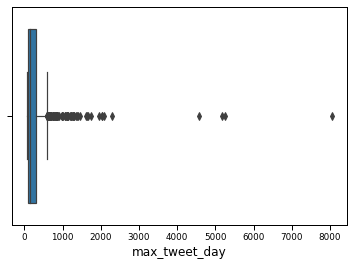

In [87]:
dt = hi_freq_users.max_tweet_day
sns.boxplot(dt);

In [88]:
dt.describe()

count    780
mean     289
std      503
min       72
25%       98
50%      148
75%      293
max     8044
Name: max_tweet_day, dtype: float64

In [89]:
# verified hi freq users
dt_hi_freq_verif_users = df_user[(df_user.max_tweet_day > 71) &
   (df_user.acc_verif == 1)]

dt_hi_freq_verif_users.user

0                    T13
13       joseantoniokast
40                  Emol
109          DFinanciero
136        adnradiochile
250          Cooperativa
302      Hugo_Gutierrez_
430            latercera
603        AgriculturaFM
833        FelipeParadaM
1120              tjholt
1445           huichalaf
1488     ahoranoticiasAN
2233         MinMujeryEG
2291            nacioncl
3079                 TVN
3283         nelsonavila
3562             segegob
6109            KarendTV
6669          ciudadanoi
7719     TroncoTorrealba
8638          MarceSabat
9911         dsocial_gob
9948          elliberocl
10364      iallendebussi
11760          lilyperez
12011          PDI_CHILE
13016          pcayuqueo
13063      paulanarvaezo
13134        tolerancia0
13433          DMatamala
13857      BeaSanchezYTu
15986       FelipeOvalle
17012     fernando_atria
19583        marcelomena
20241     PANCHOSAAVEDRA
21151           lmrendon
28428            baradit
30206           PamJiles
30797            canal13


In [90]:
dt_hi_freq_verif_users.describe().T

,count,mean,std,min,25%,50%,75%,max
default_prof_image,53,0,0,0,0,0,0,0
acc_verif,53,1,0,1,1,1,1,1
local_bol,53,1,0,0,1,1,1,1
default_profile,53,0,0,0,0,0,0,1
descr_bol,53,1,0,1,1,1,1,1
active_acc,53,1,0,0,1,1,1,1
tws_cnt,53,110099,159289,302,18110,39360,136836,776354
frs_cnt,53,53688,141746,0,907,3235,13382,761106
fols_cnt,53,566241,802036,8758,63658,151920,730875,2882527
fav_cnt,53,9885,27912,13,203,1798,7014,175107


In [91]:
dt_hi_freq_verif_users[dt_hi_freq_verif_users.active_acc == 0]

,user,default_prof_image,acc_verif,local_bol,default_profile,descr_bol,active_acc,tws_cnt,frs_cnt,fols_cnt,...,rt_ratio,mean_urls,mean_lenght,recent_age_days,user_name_len,name_len,user_name_len_num,simil_name,descr_len,fols_frs_ratio
9911,dsocial_gob,0,1,1,0,1,0,59067,1098,100919,...,19,1,183,26,11,20,0,54,72,92


In [92]:
dt_hi_freq_nv_users = df_user[(df_user.max_tweet_day > 71) &
                      (df_user.acc_verif == 0)]

print("Number of Hi Freq Non Verified Users: {}".format(
    len(dt_hi_freq_nv_users)))

Number of Hi Freq Non Verified Users: 727


In [93]:
dt_hi_freq_nv_users.describe().T

,count,mean,std,min,25%,50%,75%,max
default_prof_image,727,0,0,0,0,0,0,1
acc_verif,727,0,0,0,0,0,0,0
local_bol,727,1,0,0,1,1,1,1
default_profile,727,0,0,0,0,0,1,1
descr_bol,727,1,0,0,1,1,1,1
active_acc,727,1,0,0,1,1,1,1
tws_cnt,727,45019,74454,2,5079,17965,55611,888346
frs_cnt,727,4095,11427,0,564,1573,3673,199334
fols_cnt,727,23366,98163,1,956,2875,10626,1602245
fav_cnt,727,11936,25262,0,551,3236,11984,303133


count    636
mean     258
std      328
min       72
25%       96
50%      147
75%      289
max     5163
Name: max_tweet_day, dtype: float64

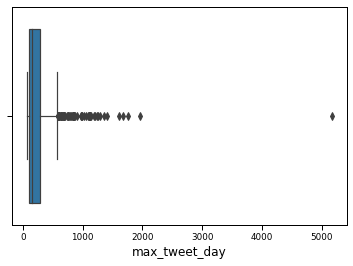

In [94]:
dt_acc = dt_hi_freq_nv_users[dt_hi_freq_nv_users.active_acc == 1]
sns.boxplot(dt_acc.max_tweet_day);
dt_acc.max_tweet_day.describe()

count    91
mean    176
std     134
min      72
25%      92
50%     128
75%     200
max     820
Name: max_tweet_day, dtype: float64

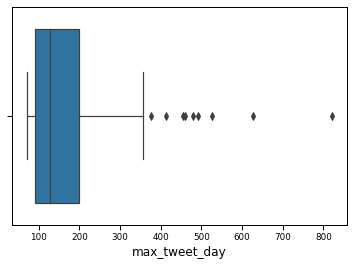

In [95]:
dt_not_acc = dt_hi_freq_nv_users[dt_hi_freq_nv_users.active_acc == 0]
sns.boxplot(dt_not_acc.max_tweet_day);
dt_not_acc.max_tweet_day.describe()

In [96]:
not_acc_hi_freq_tws = dt_not_acc.tweets_analysed.sum()
print('Number of tweets per "not active" Hi Freq Acc: {:,} ==> {}% of total tweets'.format(
    not_acc_hi_freq_tws, round((not_acc_hi_freq_tws/tot_tweets)*100, 2)))

Number of tweets per "not active" Hi Freq Acc: 41,867.0 ==> 2.8% of total tweets


`At end, the number of accounts that were actives in 2017 and not today, do not generate an important number of tweets.`

In [97]:
dt_hi_freq_nv_users.default_prof_image.value_counts()

0    723
1      4
Name: default_prof_image, dtype: int64

In [98]:
dt_hi_freq_nv_users.default_profile.value_counts()

0    465
1    262
Name: default_profile, dtype: int64

In [99]:
dt_hi_freq_nv_users.local_bol.value_counts()

1    546
0    181
Name: local_bol, dtype: int64

In [100]:
dt_hi_freq_nv_users.descr_bol.value_counts()

1    669
0     58
Name: descr_bol, dtype: int64

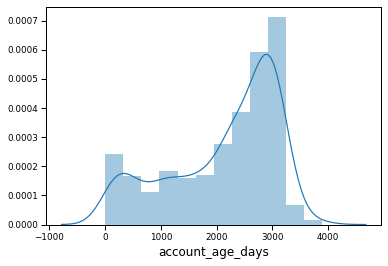

In [101]:
sns.distplot(dt_hi_freq_nv_users.account_age_days);

## Comparing High and Low Frequency, Non Verified Accounts

By DFR Lab:
- More than 72 tweets/day  ==> Bot Behavior: Suspicion
- More than 144 tweets/day ==> Bot Behavior: Highly Suspicion

By Oxford Internet Institute ==> More than 50 tweets/day posting same hachtag 

In [102]:
hf = df_user[(df_user.max_tweet_day > 144) & (df_user.acc_verif == 0)]
hf_tws = hf.tweets_analysed.sum()
print(
    'Number of tweets per each of {} "not verified" High Freq Acc: {:,} ==> {}% of total tweets'
    .format(len(hf), hf_tws, round((hf_tws / tot_tweets) * 100, 2)))

Number of tweets per each of 356 "not verified" High Freq Acc: 364,942.0 ==> 24.44% of total tweets


In [103]:
lf = df_user[(df_user.max_tweet_day < 50) & (df_user.acc_verif == 0)]
lf_tws = lf.tweets_analysed.sum()
print(
    'Number of tweets per each of {} "not verified" Low Freq Acc: {:,} ==> {}% of total tweets'
    .format(len(lf), lf_tws, round((lf_tws / tot_tweets) * 100, 2)))

Number of tweets per each of 89859 "not verified" Low Freq Acc: 775,232.0 ==> 51.92% of total tweets


In [104]:
hf.describe().T

,count,mean,std,min,25%,50%,75%,max
default_prof_image,356,0,0,0,0,0,0,0
acc_verif,356,0,0,0,0,0,0,0
local_bol,356,1,0,0,1,1,1,1
default_profile,356,0,0,0,0,0,1,1
descr_bol,356,1,0,0,1,1,1,1
active_acc,356,1,0,0,1,1,1,1
tws_cnt,356,48530,79996,2,5814,19418,61384,888346
frs_cnt,356,4610,8922,3,695,1800,4668,70858
fols_cnt,356,30867,119774,1,1794,4866,15274,1602245
fav_cnt,356,11584,27181,0,461,2910,9918,303133


In [28]:
lf.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,89859,45973,26174,1,23386,46051,68638,91153
default_prof_image,89859,0,0,0,0,0,0,1
acc_verif,89859,0,0,0,0,0,0,0
local_bol,89859,1,0,0,0,1,1,1
default_profile,89859,1,0,0,0,1,1,1
descr_bol,89859,1,0,0,0,1,1,1
active_acc,89859,1,0,0,1,1,1,1
tws_cnt,89859,8682,26820,1,225,1360,6330,1386920
frs_cnt,89859,684,1874,0,105,296,757,150927
fols_cnt,89859,893,10141,0,32,137,477,1605933


In [155]:
def plot_feat_comp(feat, prt=False, save_file_name=None, x_max = None):
    feat1 = hf[feat]
    feat2 = lf[feat]
    fig, axes = plt.subplots(ncols=1, figsize=(10, 5))
    #fig = plt.figure(figsize = (10,5))
    sns.distplot(feat1,
                 color="m",
                 label='High Frequency',
                 hist=False,
                 kde=True,
                 kde_kws={
                     'shade': True,
                     'linewidth': 3
                 })
    plt.xlim(0, x_max)
    
    sns.distplot(feat2,
                 color="g",
                 label='Low Frequency',
                 hist=False,
                 kde=True,
                 kde_kws={
                     'shade': True,
                     'linewidth': 3
                 })
    plt.xlim(0, x_max)
    plt.suptitle(feat+' distribution', fontsize=16)
    sns.despine(left=True)
    plt.setp(axes, yticks=[])
    
    if prt == True:
        plt.savefig("../images/"+save_file_name, bbox_inches='tight')

In [140]:
def plot_feat_comp_2_graph(feat, prt=False, save_file_name=None):
    low_freq = lf[feat]
    high_freq = hf[feat]
    f, axes = plt.subplots(ncols=2, figsize=(10, 4))
    sns.despine(left=True)
    sns.distplot(high_freq,
                 color="m",
                 label='High Frequency',
                 hist=False,
                 kde=True,
                 kde_kws={
                     'shade': True,
                     'linewidth': 3
                 },
                 ax=axes[0])
    sns.distplot(low_freq,
                 color="g",
                 label='Low Frequency',
                 hist=False,
                 kde=True,
                 kde_kws={
                     'shade': True,
                     'linewidth': 3
                 },
                 ax=axes[1])
    plt.suptitle(feat + " distribution", fontsize=16)
    plt.setp(axes, yticks=[])
    
    if prt == True:
        plt.savefig("../images/"+save_file_name, bbox_inches='tight')

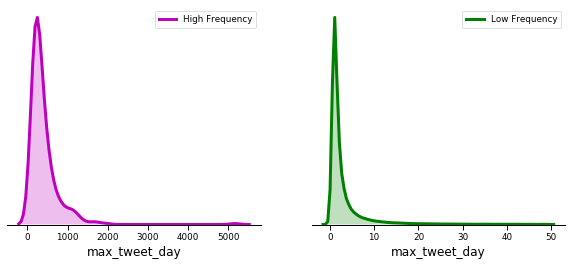

In [215]:
feat = 'max_tweet_day'
plot_feat_comp_2_graph(feat, prt=True, save_file_name='max_tweet_day')

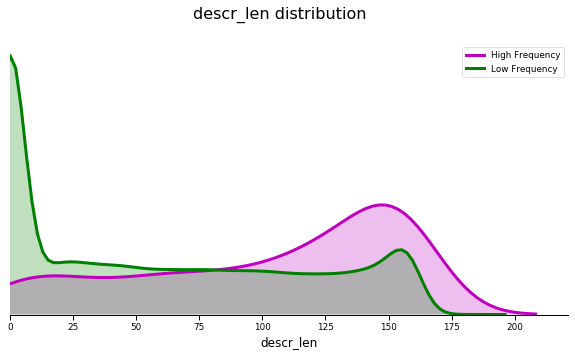

In [214]:
plot_feat_comp('descr_len', prt=True, save_file_name="Account_Description_Lengths") 

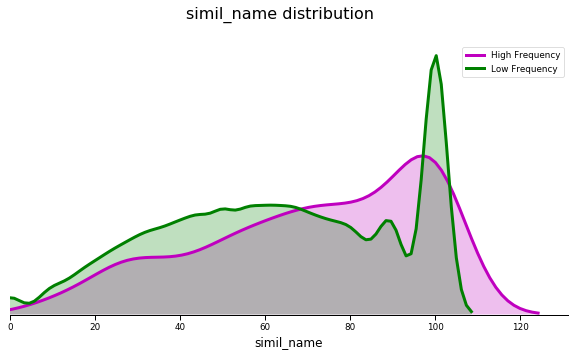

In [160]:
plot_feat_comp('simil_name') 

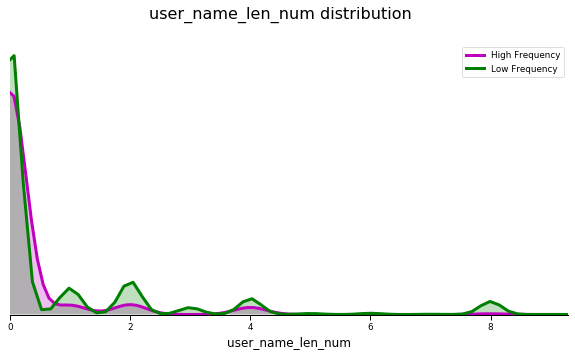

In [161]:
plot_feat_comp('user_name_len_num') 

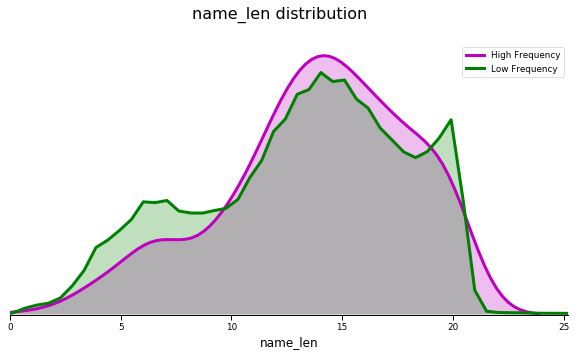

In [162]:
plot_feat_comp('name_len') 

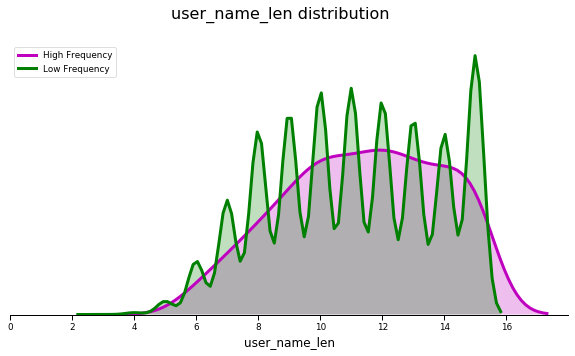

In [163]:
plot_feat_comp('user_name_len') 

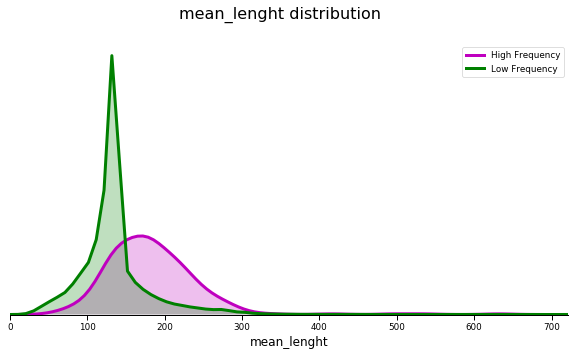

In [198]:
plot_feat_comp('mean_lenght', prt=True, save_file_name="hf_lf_mean_length" ) 

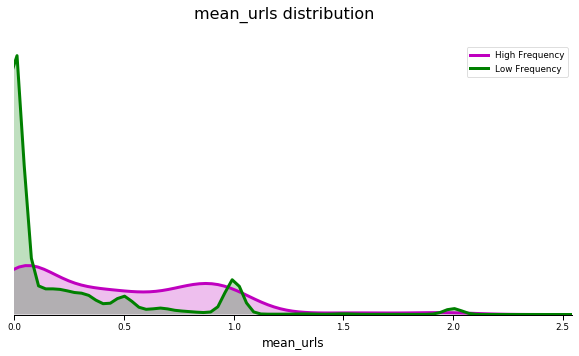

In [165]:
plot_feat_comp('mean_urls') 

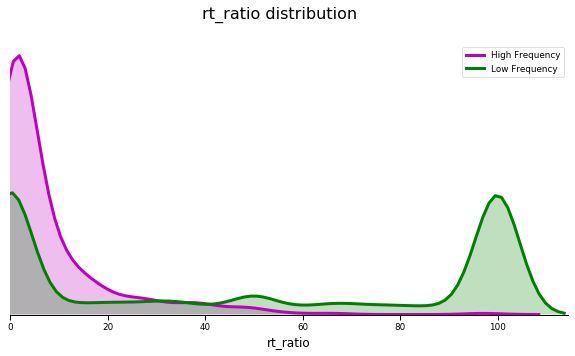

In [181]:
plot_feat_comp('rt_ratio', prt=True, save_file_name="hf_lf_rt_ratio" ) # (rt_tweets_cnt/tweets_analysed)*100

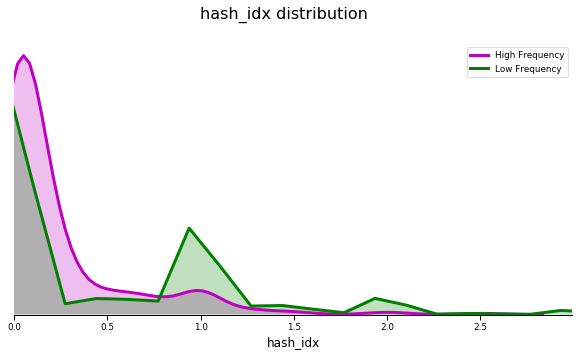

In [167]:
plot_feat_comp('hash_idx') # unique_hashtags_cnt/hash_tweets_cnt

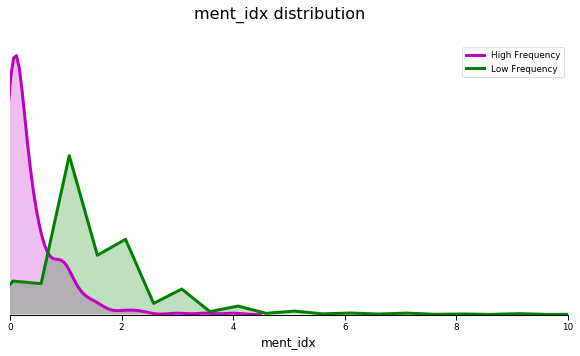

In [200]:
plot_feat_comp('ment_idx',
               prt=True,
               save_file_name="hf_lf_mention_index",
               x_max=10)  # unique_mentions_cnt/ment_tweets_cnt

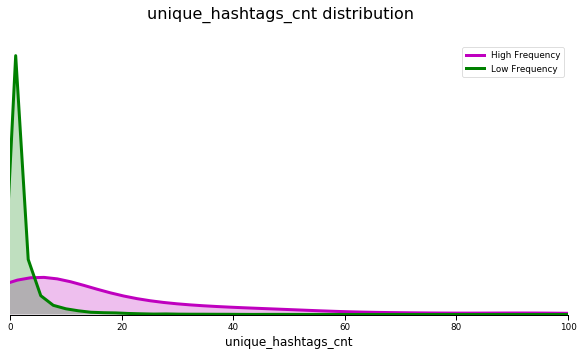

In [201]:
plot_feat_comp('unique_hashtags_cnt', prt=True, save_file_name="hf_lf_unique_hashtag_cnt", x_max=100)

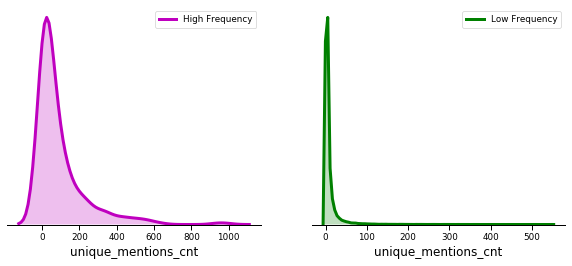

In [174]:
plot_feat_comp_2_graph('unique_mentions_cnt')

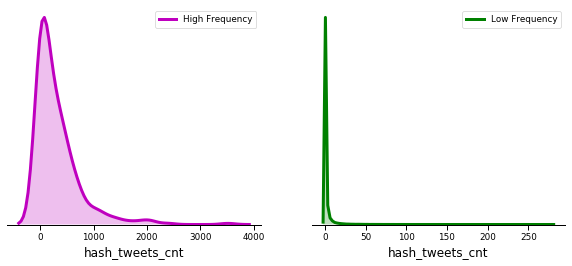

In [180]:
plot_feat_comp_2_graph('hash_tweets_cnt')

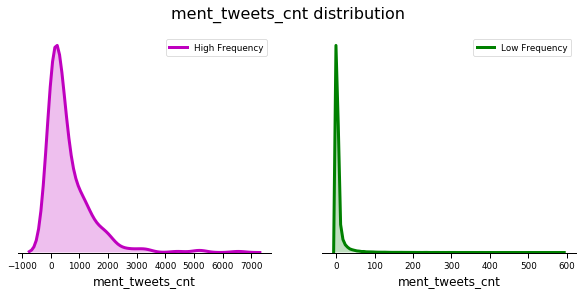

In [130]:
plot_feat_comp_2_graph('ment_tweets_cnt')

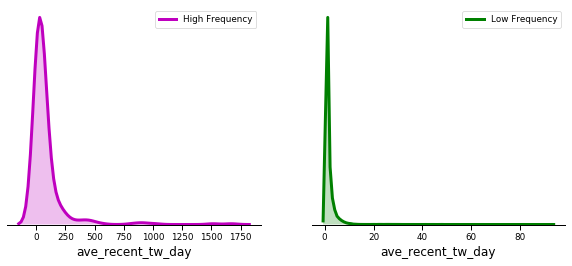

In [185]:
plot_feat_comp_2_graph('ave_recent_tw_day')

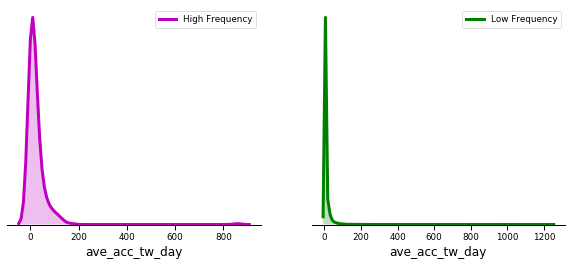

In [187]:
plot_feat_comp_2_graph('ave_acc_tw_day')

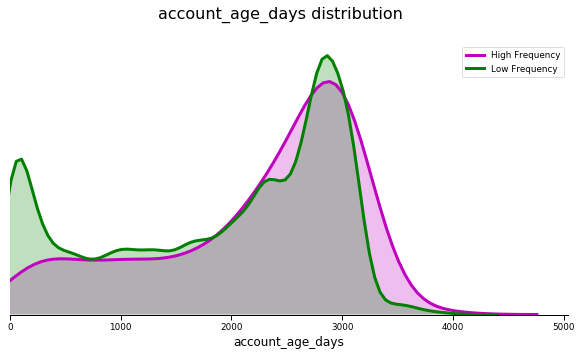

In [178]:
plot_feat_comp('account_age_days', prt=True, save_file_name="hf_lf_account_age" )

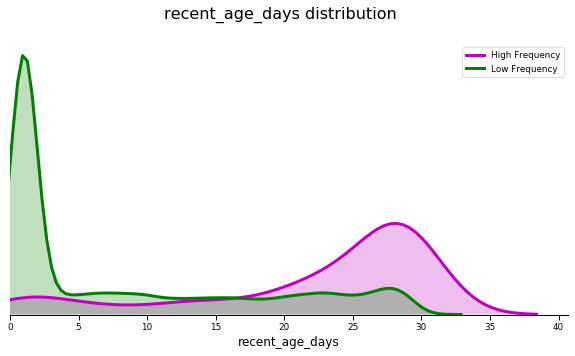

In [182]:
plot_feat_comp('recent_age_days', prt=True, save_file_name="hf_lf_recent_account_age" )

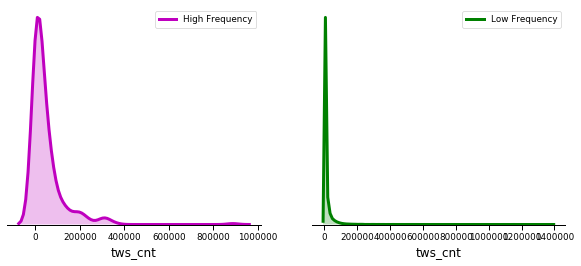

In [189]:
plot_feat_comp_2_graph('tws_cnt')

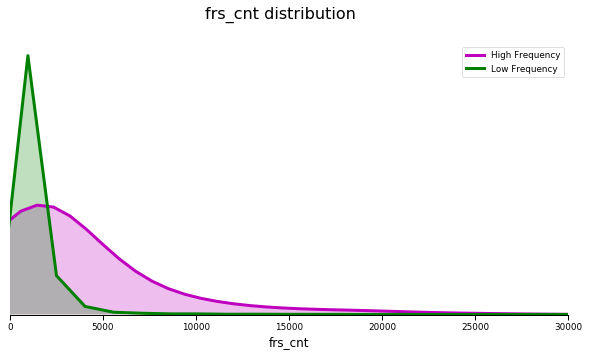

In [202]:
plot_feat_comp('frs_cnt', prt=True, save_file_name="hf_lf_rt_friends", x_max=30_000)

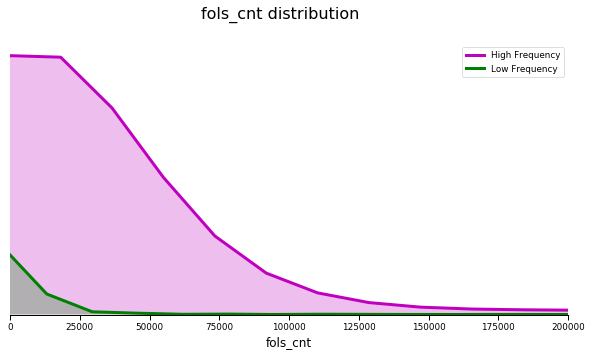

In [204]:
plot_feat_comp('fols_cnt', prt=True, save_file_name="hf_lf_followers", x_max=200_000)

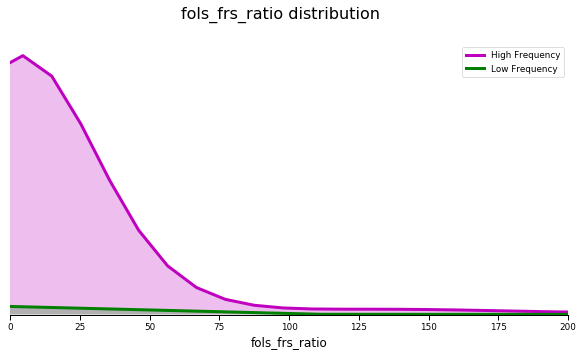

In [195]:
plot_feat_comp('fols_frs_ratio', x_max=200) # followers / Following

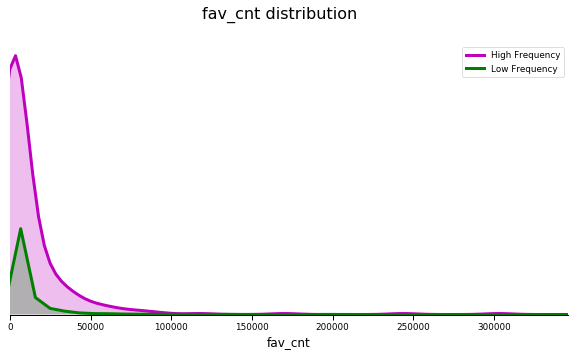

In [196]:
plot_feat_comp('fav_cnt') # likes

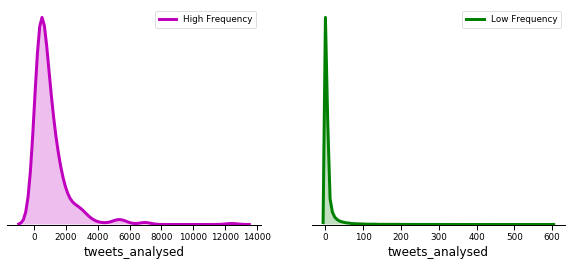

In [197]:
plot_feat_comp_2_graph('tweets_analysed')

### Creating Label with User Frequency

In [205]:
def add_freq_label(row): 
    
    freq = row['max_tweet_day']
    if freq < 50: 
        label = 'low_freq'
    elif freq > 144: 
        label = 'high_freq'
    else: 
        label = 'mid_freq'
        
    row['label'] = label

    return row

In [206]:
df_user = df_user.apply(add_freq_label, axis=1)

In [208]:
df_user.label.value_counts()

low_freq     89959
mid_freq       798
high_freq      397
Name: label, dtype: int64

In [209]:
df_user.to_csv("../data/60_user_metrics_label.csv")

In [211]:
df_user.columns

Index(['user', 'default_prof_image', 'acc_verif', 'local_bol',
       'default_profile', 'descr_bol', 'active_acc', 'tws_cnt', 'frs_cnt',
       'fols_cnt', 'fav_cnt', 'tweets_analysed', 'account_age_days',
       'ave_acc_tw_day', 'ave_recent_tw_day', 'max_tweet_day',
       'ment_tweets_cnt', 'hash_tweets_cnt', 'unique_mentions_cnt',
       'unique_hashtags_cnt', 'ment_idx', 'hash_idx', 'rt_ratio', 'mean_urls',
       'mean_lenght', 'recent_age_days', 'user_name_len', 'name_len',
       'user_name_len_num', 'simil_name', 'descr_len', 'fols_frs_ratio',
       'label'],
      dtype='object')

In [212]:
data = df_user[['fols_frs_ratio', 'rt_ratio', 'max_tweet_day', 'account_age_days', 'label']]

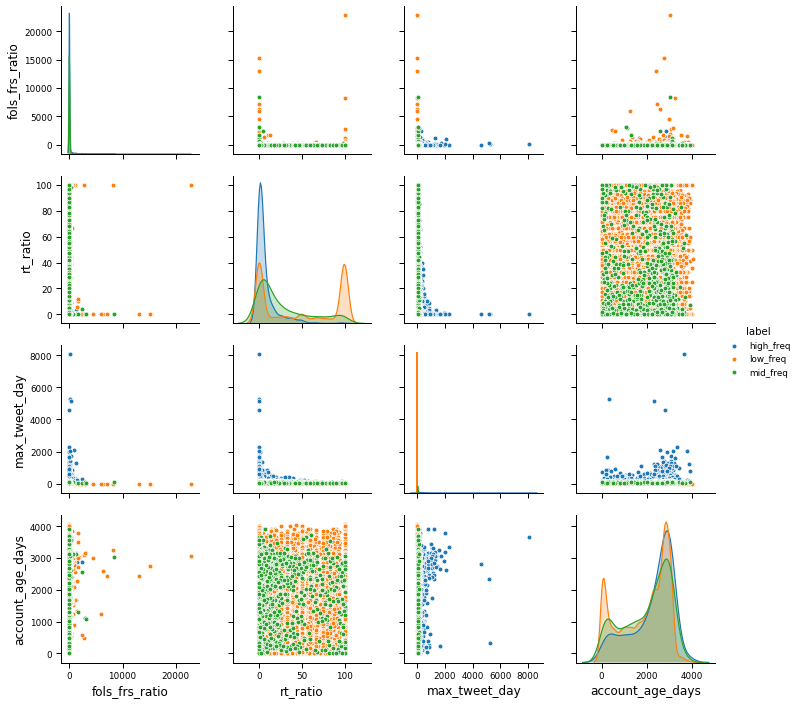

In [213]:
sns.pairplot(data, diag_kind="kde", hue='label');

---

# Analyzing Suspicious Users from its Tweets

In [221]:
ls ../data/

20_tweets_nov_2017.csv             50_user_metrics_final.csv
30_tweets_nov_2017_final.csv       60_user_metrics_label.csv
40_user_metrics.csv                df_user_description.csv
45_user_adit_clean_metrics.csv     select_tweet_feat_description.csv


In [222]:
tweets = pd.read_csv("../data/30_tweets_nov_2017_final.csv", lineterminator='\n')
tweets.shape

(1601643, 36)

In [223]:
del tweets['Unnamed: 0']

In [224]:
tweets.description.fillna('', inplace=True)
tweets.location.fillna('', inplace=True)

In [225]:
tweets['created_at'] = pd.to_datetime(tweets['created_at'], infer_datetime_format = "%d/%m/%Y", utc  = False)
tweets['acc_creation'] = pd.to_datetime(tweets['acc_creation'], infer_datetime_format = "%d/%m/%Y", utc  = False)

In [226]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1601643 entries, 0 to 1601642
Data columns (total 35 columns):
user_id               1601643 non-null int64
user                  1601643 non-null object
name                  1601576 non-null object
description           1601643 non-null object
verified              1601643 non-null bool
protected             1601643 non-null bool
location              1601643 non-null object
lang                  1601643 non-null object
followers             1601643 non-null int64
following             1601643 non-null int64
favourites            1601643 non-null int64
lists                 1601643 non-null int64
tweets_cnt            1601643 non-null int64
acc_creation          1601643 non-null datetime64[ns, UTC]
default_profile       1601643 non-null bool
default_prof_image    1601643 non-null bool
image                 1601643 non-null object
text                  1601643 non-null object
tweet_id              1601643 non-null int64
created_at     

##  Possible Simple Bots Users Analysis

In [283]:
simple_bots = df_user[(df_user.acc_verif == 0)
                      & (df_user.default_prof_image == 1)
                      & ((df_user.default_profile == 1)
                         | (df_user.descr_bol == 0))
                      & (df_user.max_tweet_day > 72)]
simple_bots.shape

(3, 33)

In [220]:
simple_bots

,user,default_prof_image,acc_verif,local_bol,default_profile,descr_bol,active_acc,tws_cnt,frs_cnt,fols_cnt,...,mean_urls,mean_lenght,recent_age_days,user_name_len,name_len,user_name_len_num,simil_name,descr_len,fols_frs_ratio,label
1381,fedoraletelier,1,0,0,1,0,1,215069,1886,2242,...,0,136,28,14,14,0,100,0,1,mid_freq
6148,Aliciacarafipl3,1,0,0,1,0,1,25781,113,200,...,0,140,29,15,20,1,78,0,2,mid_freq
13523,Dolores09072598,1,0,0,1,0,1,96,300,28,...,0,129,27,15,13,8,67,0,0,mid_freq


In [234]:
simple_bots_users_lst = list(simple_bots.user)


Info Data for @fedoraletelier

Name:                       fedoraletelier
Name Length:                14
@user number Numeric Chars: 0
@user and name similarity:  100.0
User Id:                    2465345439
Default_Photo:              True
Photo URL:                  http://abs.twimg.com/sticky/default_profile_images/default_profile_normal.png
Acc Verified:               False
Has Location:               False
Location:                   
default_profile:            True
Has Description:            False
Description:                
Description length:         0
Account Active:             True

Number of Tweets analyzed:          690
Last Tweet:                         2017-11-29T19:27:32.000000000
Older Tweet Analyzed:               2017-10-31T23:07:51.000000000
Account Active age (in days)        1,333.0
Average recent tweets per day:      24.64
Maximum Recent Tweets Per Day:      85
Average tweets per day since start: 161.34
Total Tweets since start:           215,069
Followers_c

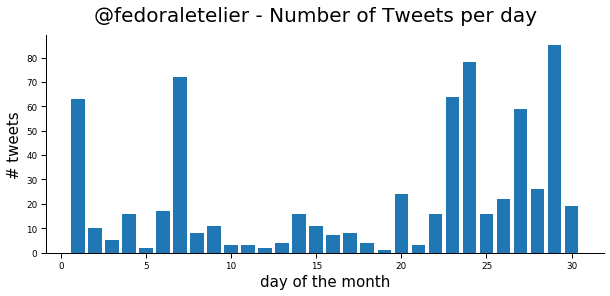

In [332]:
tw_day, metrics, mentions, hastags = get_info_data(simple_bots_users_lst[0])


Info Data for @Aliciacarafipl3

Name:                       Aliciacarafiplanella
Name Length:                20
@user number Numeric Chars: 1
@user and name similarity:  77.77777777777779
User Id:                    801131674402701312
Default_Photo:              True
Photo URL:                  http://abs.twimg.com/sticky/default_profile_images/default_profile_normal.png
Acc Verified:               False
Has Location:               False
Location:                   
default_profile:            True
Has Description:            False
Description:                
Description length:         0
Account Active:             True

Number of Tweets analyzed:          747
Last Tweet:                         2017-11-30T22:22:11.000000000
Older Tweet Analyzed:               2017-11-01T21:52:14.000000000
Account Active age (in days)        373.0
Average recent tweets per day:      25.76
Maximum Recent Tweets Per Day:      78
Average tweets per day since start: 69.12
Total Tweets since start:      

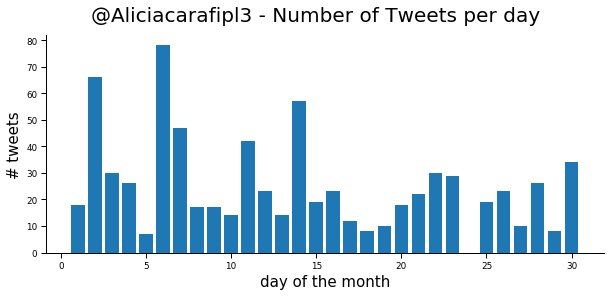

In [333]:
tw_day, metrics, mentions, hastags = get_info_data(simple_bots_users_lst[1])


Info Data for @Dolores09072598

Name:                       Dolores Nunez
Name Length:                13
@user number Numeric Chars: 8
@user and name similarity:  66.66666666666666
User Id:                    874119200205418497
Default_Photo:              True
Photo URL:                  http://abs.twimg.com/sticky/default_profile_images/default_profile_normal.png
Acc Verified:               False
Has Location:               False
Location:                   
default_profile:            True
Has Description:            False
Description:                
Description length:         0
Account Active:             True

Number of Tweets analyzed:          431
Last Tweet:                         2017-11-30T18:54:12.000000000
Older Tweet Analyzed:               2017-11-03T04:13:46.000000000
Account Active age (in days)        171.0
Average recent tweets per day:      15.96
Maximum Recent Tweets Per Day:      113
Average tweets per day since start: 0.56
Total Tweets since start:           96

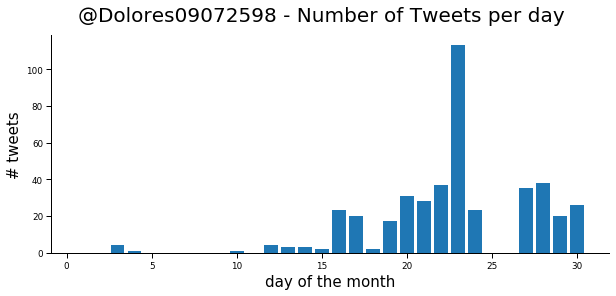

In [334]:
tw_day, metrics, mentions, hastags = get_info_data(simple_bots_users_lst[2])

## Analyze Hi Frequency "Non-Verified" Users

In [299]:
hi_freq_users = df_user[(df_user.acc_verif == 0)
                      & (df_user.max_tweet_day > 144)]
hi_freq_users.shape

(356, 33)

In [302]:
hi_freq_users_lst = list(hi_freq_users.user)

In [303]:
hi_freq_users_order_lst = get_max_tweet_day(tweets, hi_freq_users_lst)

In [304]:
hi_freq_users_order_lst

[('AlbertoMayol', 5163),
 ('Tomaskovacic', 1962),
 ('lagosweber', 1752),
 ('NelsonCL28', 1669),
 ('MaxValdesC', 1605),
 ('paulfontaineb', 1407),
 ('NachoOrtega', 1362),
 ('robertoampuero', 1294),
 ('suberca', 1263),
 ('Monojacoby', 1237),
 ('sergioulloa1', 1205),
 ('lcruzcoke', 1195),
 ('albertoespina', 1139),
 ('gransopi', 1128),
 ('Movilh', 1123),
 ('illapu', 1119),
 ('Flavioqr', 1111),
 ('marcatuvoto', 1103),
 ('GmoRamirez', 1102),
 ('tere_marinovic', 1082),
 ('KarlaEnAccion', 1062),
 ('DraJuguete37', 1014),
 ('dmimica', 986),
 ('DValdebenitoA', 984),
 ('hernan_sr', 976),
 ('manuelotec', 974),
 ('T13valpo', 905),
 ('CarlosAmpuero', 866),
 ('la_tera_vive', 857),
 ('cesarioncamilo', 854),
 ('EstoyConPinera', 848),
 ('andres20der', 842),
 ('Patolinsky', 831),
 ('GiorgioJackson', 830),
 ('S_riesenberg', 826),
 ('Ange_GossowF', 820),
 ('jocanavarro', 800),
 ('Dane_BS', 791),
 ('carlitos_huerta', 772),
 ('AhUeOnAdO', 749),
 ('EncuestaExpress', 748),
 ('jgalemparte', 735),
 ('Chile_Alerta'


Info Data for @AlbertoMayol

Name:                       Alberto Mayol
Name Length:                13
@user number Numeric Chars: 0
@user and name similarity:  100.0
User Id:                    337542243
Default_Photo:              False
Photo URL:                  http://pbs.twimg.com/profile_images/892780474829078530/4VeDYUuZ_normal.jpg
Acc Verified:               False
Has Location:               False
Location:                   
default_profile:            True
Has Description:            True
Description:                Papá de Alessandro, esposo de Claudia, militante del Frente Amplio y de la U. Con el corazón a la izquierda.
Description length:         108
Account Active:             True

Number of Tweets analyzed:          6930
Last Tweet:                         2017-11-28T15:55:56.000000000
Older Tweet Analyzed:               2017-11-13T01:51:06.000000000
Account Active age (in days)        2,325.0
Average recent tweets per day:      462.0
Maximum Recent Tweets Per Day:   

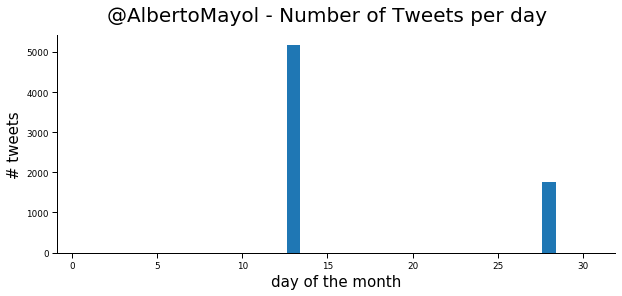

In [338]:
user_name = 'AlbertoMayol'
tw_day, metrics, mentions, hastags = get_info_data(tweets, user_name)

In [311]:
tweets[(tweets.user == user_name)].text

403036     Impresionante que @sebastianpinera sea incapaz...
403061     Impresionante que @sebastianpinera sea incapaz...
403075     Impresionante que @sebastianpinera sea incapaz...
403078     Impresionante que @sebastianpinera sea incapaz...
403083     Impresionante que @sebastianpinera sea incapaz...
403085     Impresionante que @sebastianpinera sea incapaz...
403095     Impresionante que @sebastianpinera sea incapaz...
403097     Impresionante que @sebastianpinera sea incapaz...
403098     Impresionante que @sebastianpinera sea incapaz...
403100     Impresionante que @sebastianpinera sea incapaz...
403106     Impresionante que @sebastianpinera sea incapaz...
403121     Impresionante que @sebastianpinera sea incapaz...
403131     Impresionante que @sebastianpinera sea incapaz...
403135     Impresionante que @sebastianpinera sea incapaz...
403139     Impresionante que @sebastianpinera sea incapaz...
403148     Impresionante que @sebastianpinera sea incapaz...
403151     Impresionante

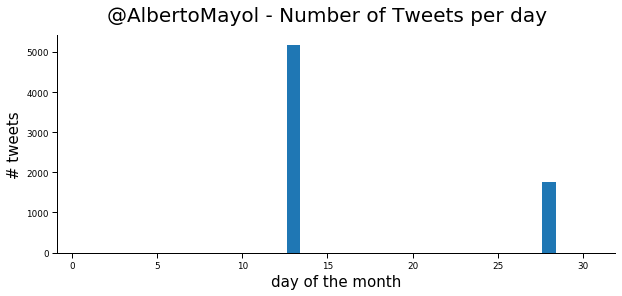

In [329]:
plot_user_timeline(user_name, tw_day, True)

In [ ]:
user_name = 'AlbertoMayol'
tw_day, metrics, mentions, hastags = get_info_data(tweets, user_name)


Info Data for @996_911

Name:                       11.9.73
Name Length:                7
@user number Numeric Chars: 3
@user and name similarity:  0
User Id:                    2888525279
Default_Photo:              False
Photo URL:                  http://pbs.twimg.com/profile_images/555949088211206146/L68-9G7D_normal.jpeg
Acc Verified:               False
Has Location:               False
Location:                   
default_profile:            True
Has Description:            True
Description:                Chileno agradecido de FFAA .Esposo,Padre,Hijo,Creyente, Cruzado de corazon trabajador honrado / Uso la Izquieda solo para subirme al caballo .
Description length:         142
Account Active:             True

Number of Tweets analyzed:          347
Last Tweet:                         2017-11-28T19:57:48.000000000
Older Tweet Analyzed:               2017-10-31T02:28:09.000000000
Account Active age (in days)        1,101.0
Average recent tweets per day:      12.39
Maximum Recent

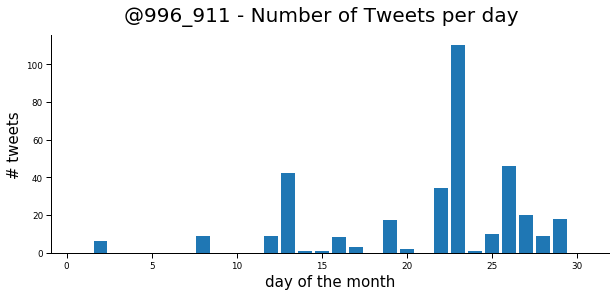

In [339]:
user_name = '996_911'
tw_day, metrics, mentions, hastags = get_info_data(tweets, user_name)


Info Data for @Tomaskovacic

Name:                       Tomas Iturbe Covacic
Name Length:                20
@user number Numeric Chars: 0
@user and name similarity:  61.53846153846154
User Id:                    94687772
Default_Photo:              False
Photo URL:                  http://pbs.twimg.com/profile_images/892574143840796672/j37U6wrm_normal.jpg
Acc Verified:               False
Has Location:               True
Location:                   Viña del Mar
default_profile:            False
Has Description:            True
Description:                Ingeniero Comercial | Economista en formación | Coordinador Nacional de @LaBrujulaCL | Viñamarino y Cruzado
Description length:         107
Account Active:             True

Number of Tweets analyzed:          2062
Last Tweet:                         2017-11-30T16:06:34.000000000
Older Tweet Analyzed:               2017-11-01T15:58:23.000000000
Account Active age (in days)        2,917.0
Average recent tweets per day:      71.1
Maxim

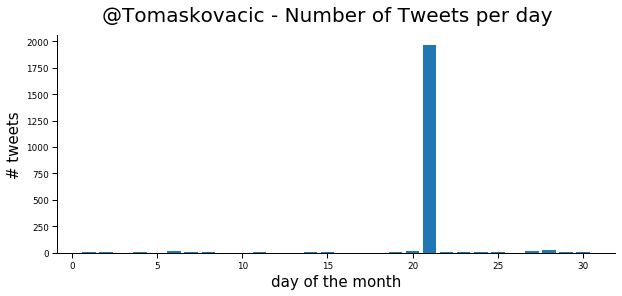

In [341]:
user_name = 'Tomaskovacic'
tw_day, metrics, mentions, hastags = get_info_data(tweets, user_name)


Info Data for @andres20ad

Name:                       Andrés
Name Length:                6
@user number Numeric Chars: 2
@user and name similarity:  83.33333333333334
User Id:                    762803779737616384
Default_Photo:              False
Photo URL:                  http://pbs.twimg.com/profile_images/762806106284515328/y4AvLMUb_normal.jpg
Acc Verified:               False
Has Location:               False
Location:                   
default_profile:            True
Has Description:            True
Description:                Uno de muchos, que luchan por mejorar este mundo, con mayor justicia, solidaridad e igualdad
Description length:         92
Account Active:             True

Number of Tweets analyzed:          3060
Last Tweet:                         2017-11-30T23:43:09.000000000
Older Tweet Analyzed:               2017-11-03T02:54:41.000000000
Account Active age (in days)        478.0
Average recent tweets per day:      113.33
Maximum Recent Tweets Per Day:      1583

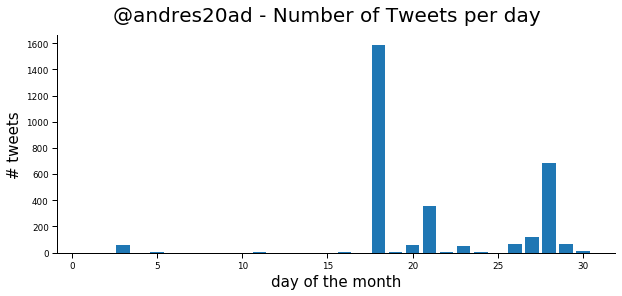

In [344]:
user_name = 'andres20ad'
tw_day, metrics, mentions, hastags = get_info_data(tweets, user_name, prt=True)

/Users/mjrovai/anaconda3/envs/python_3_7/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in double_scalars



Info Data for @NelsonCL28

Name:                       Nelson Sánchez G.
Name Length:                17
@user number Numeric Chars: 2
@user and name similarity:  66.66666666666666
User Id:                    175420136
Default_Photo:              False
Photo URL:                  http://pbs.twimg.com/profile_images/932340297916387328/uUSFt7NI_normal.jpg
Acc Verified:               False
Has Location:               True
Location:                   Valparaíso, Chile
default_profile:            False
Has Description:            True
Description:                Praise Kek!
Description length:         11
Account Active:             True

Number of Tweets analyzed:          1669
Last Tweet:                         2017-11-19T20:20:33.000000000
Older Tweet Analyzed:               2017-11-19T20:20:33.000000000
Account Active age (in days)        2,662.0
Average recent tweets per day:      inf
Maximum Recent Tweets Per Day:      1669
Average tweets per day since start: 0.02
Total Tweets since s

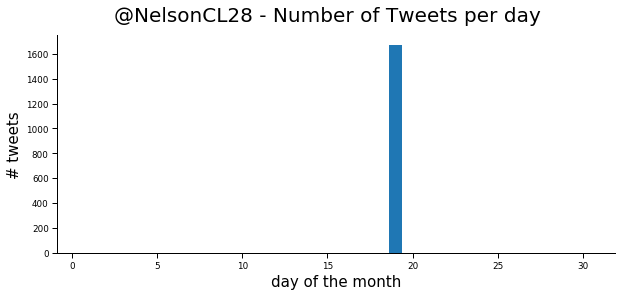

In [348]:
user_name = 'NelsonCL28'
tw_day, metrics, mentions, hastags = get_info_data(tweets, user_name, prt=True)


Info Data for @Ivonomas

Name:                       Ivo Barrientos
Name Length:                14
@user number Numeric Chars: 0
@user and name similarity:  54.54545454545454
User Id:                    1677545442
Default_Photo:              False
Photo URL:                  http://pbs.twimg.com/profile_images/378800000311704613/57dba5d1d296053000c81f1acbf9cd60_normal.jpeg
Acc Verified:               False
Has Location:               False
Location:                   
default_profile:            True
Has Description:            True
Description:                periodista sin título que busca solamente desenmascarar la demagogia que abunda en este espacio. Si me mencionas te hago RT.
Description length:         124
Account Active:             True

Number of Tweets analyzed:          299
Last Tweet:                         2017-11-30T21:03:14.000000000
Older Tweet Analyzed:               2017-11-01T07:09:21.000000000
Account Active age (in days)        1,566.0
Average recent tweets per

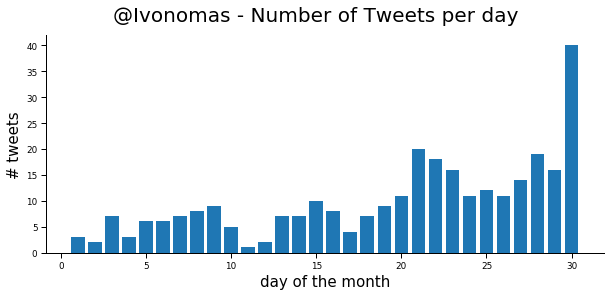

In [345]:
user_name = 'Ivonomas'
tw_day, metrics, mentions, hastags = get_info_data(tweets, user_name)

## Verified account that was canceled by Twitter


Info Data for @dsocial_gob

Name:                       MinDesarrollo Social
Name Length:                20
@user number Numeric Chars: 0
@user and name similarity:  53.84615384615385
User Id:                    115091645
Default_Photo:              False
Photo URL:                  http://pbs.twimg.com/profile_images/882979542339596291/WEWLSieR_normal.jpg
Acc Verified:               True
Has Location:               True
Location:                   Catedral 1575, Santiago
default_profile:            False
Has Description:            True
Description:                Twitter oficial del Ministerio De Desarrollo Social del @gobiernodechile
Description length:         72
Account Active:             False

Number of Tweets analyzed:          334
Last Tweet:                         2017-11-28T14:18:44.000000000
Older Tweet Analyzed:               2017-11-02T12:31:52.000000000
Account Active age (in days)        2,840.0
Average recent tweets per day:      12.85
Maximum Recent Tweets Per Day:

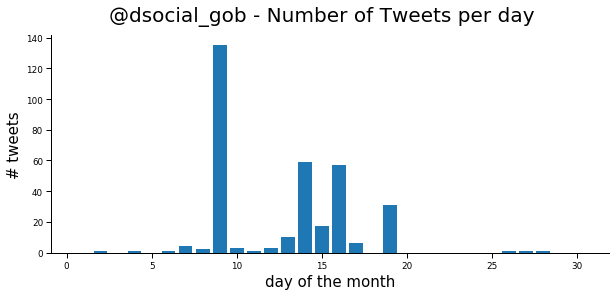

In [346]:
user_name = 'dsocial_gob'
tw_day, metrics, mentions, hastags = get_info_data(tweets, user_name)